In [1]:
pip install pycaret

     |████████████████████████████████| 320 kB 282 kB/s 
     |████████████████████████████████| 167 kB 3.7 MB/s 
     |████████████████████████████████| 6.8 MB 3.8 MB/s 
     |████████████████████████████████| 141 kB 24.8 MB/s 
     |████████████████████████████████| 24.2 MB 830 kB/s 
     |████████████████████████████████| 17.0 MB 172 kB/s 
     |████████████████████████████████| 77 kB 4.6 MB/s 
     |████████████████████████████████| 1.6 MB 42.9 MB/s 
     |████████████████████████████████| 79 kB 5.7 MB/s 
     |████████████████████████████████| 151 kB 32.7 MB/s 
     |████████████████████████████████| 514 kB 39.1 MB/s 
     |████████████████████████████████| 1.7 MB 61.6 MB/s 
  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... - done
  Installing backend dependencies ... - \ | done
    Preparing wheel metadata ... - done
     |████████████████████████████████| 1.7 MB 58.9 MB/s 
  Created wheel for databricks-cli: filename=dat

In [2]:
pip install scikit-learn==0.23.2

Note: you may need to restart the kernel to use updated packages.


In [3]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import math

from scipy import stats
import seaborn as sns
sns.set_style('darkgrid')

### Model packages
from sklearn import preprocessing
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score

from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge, HuberRegressor, Ridge, OrthogonalMatchingPursuit, Lasso
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

sns.set_style("darkgrid")

pd.set_option('display.max_rows', 90)
pd.set_option('display.max_columns', 250)


/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Housing Prices Dataset

Lets take a look at the House Prices - Advanced Regression Techniques dataset. This is a somewhat large dataset with 79 explanatory variables so there is plenty of room for analysis. Here are some rough steps.

## Steps of Data Exploration
1. Variable Identification
2. Missing Value Treatment/Cleaning
    * Ensure Proper Data Types
    * Missing Value Imputation
        * Catagorical Imputation
        * Continuous Imputation
3. Feature Engineering
    * Variable Creation
    * Target Transformation
    * Variable Transformation
    * Bivariate Analysis
    * Feature Selection
    * Preprocessing
4. Model Building 
    * Bias/Variance Analysis
    * Hyperparameter tuning
    * Ensembling
    
I will do my best to work through the given steps in order.


# 1. Variable Identification

Here we're just looking for the independent/response and dependent/explanatory variables. We also would like to classify what type of variables these are to begin our analysis. This is somewhat done for us already due to the nature of the data. Lets grab our data and take a look. 

Because this is a competition and not a model being used to be put into production, we can combine the test and train datasets to have more information for our steps. All we are interested in is optimizing our prediction at the end.

In [4]:
#Here I will read the csvs, and print the dimensions of the datasets. Additionally, I will combine the datasets and look at the first few columns.


train0 = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test0 = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

train_id = train0.Id
test_id = test0.Id

target = train0['SalePrice']
train1 = train0.drop(['SalePrice', 'Id'], axis = 1)
test1 = test0.drop(['Id'], axis = 1)

data1 = pd.concat([train1,test1], axis = 0).reset_index(drop = True)

print("Train set: ", train0.shape)
print("Test set: ", test0.shape)

train0.info()

Train set:  (1460, 81)
Test set:  (1459, 80)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  Overall

In [5]:
train0.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [6]:
#Some descriptive stats for continuous variables.
train0.describe().round(3)

Id  MSSubClass  LotFrontage     LotArea  OverallQual  OverallCond  \
count  1460.00    1460.000     1201.000    1460.000     1460.000     1460.000   
mean    730.50      56.897       70.050   10516.828        6.099        5.575   
std     421.61      42.301       24.285    9981.265        1.383        1.113   
min       1.00      20.000       21.000    1300.000        1.000        1.000   
25%     365.75      20.000       59.000    7553.500        5.000        5.000   
50%     730.50      50.000       69.000    9478.500        6.000        5.000   
75%    1095.25      70.000       80.000   11601.500        7.000        6.000   
max    1460.00     190.000      313.000  215245.000       10.000        9.000   

       YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
count   1460.000      1460.000    1452.000    1460.000    1460.000   1460.000   
mean    1971.268      1984.866     103.685     443.640      46.549    567.240   
std       30.203        20.645     181.066     456.098     161.319    441.867   
min     1872.000      1950.000       0.000       0.000       0.000      0.000   
25%     1954.000      1967.000       0.000       0.000       0.000    223.000   
50%     1973.000      1994.000       0.000     383.500       0.000    477.500   
75%     2000.000      2004.000     166.000     712.250       0.000    808.000   
max     2010.000      2010.000    1600.000    5644.000    1474.000   2336.000   

       TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  \
count     1460.000  1460.000  1460.000      1460.000   1460.000      1460.000   
mean      1057.429  1162.627   346.992         5.845   1515.464         0.425   
std        438.705   386.588   436.528        48.623    525.480         0.519   
min          0.000   334.000     0.000         0.000    334.000         0.000   
25%        795.750   882.000     0.000         0.000   1129.500         0.000   
50%        991.500  1087.000     0.000         0.000   1464.000         0.000   
75%       1298.250  1391.250   728.000         0.000   1776.750         1.000   
max       6110.000  4692.000  2065.000       572.000   5642.000         3.000   

       BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
count      1460.000  1460.000  1460.000      1460.000      1460.000   
mean          0.058     1.565     0.383         2.866         1.047   
std           0.239     0.551     0.503         0.816         0.220   
min           0.000     0.000     0.000         0.000         0.000   
25%           0.000     1.000     0.000         2.000         1.000   
50%           0.000     2.000     0.000         3.000         1.000   
75%           0.000     2.000     1.000         3.000         1.000   
max           2.000     3.000     2.000         8.000         3.000   

       TotRmsAbvGrd  Fireplaces  GarageYrBlt  GarageCars  GarageArea  \
count      1460.000    1460.000     1379.000    1460.000    1460.000   
mean          6.518       0.613     1978.506       1.767     472.980   
std           1.625       0.645       24.690       0.747     213.805   
min           2.000       0.000     1900.000       0.000       0.000   
25%           5.000       0.000     1961.000       1.000     334.500   
50%           6.000       1.000     1980.000       2.000     480.000   
75%           7.000       1.000     2002.000       2.000     576.000   
max          14.000       3.000     2010.000       4.000    1418.000   

       WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
count    1460.000     1460.000       1460.000   1460.000     1460.000   
mean       94.245       46.660         21.954      3.410       15.061   
std       125.339       66.256         61.119     29.317       55.757   
min         0.000        0.000          0.000      0.000        0.000   
25%         0.000        0.000          0.000      0.000        0.000   
50%         0.000       25.000          0.000      0.000        0.000   
75%       168.000     

In [7]:
#Descriptive stats about categorical variables.
train0.describe(include = ["O"])

MSZoning Street Alley LotShape LandContour Utilities LotConfig  \
count      1460   1460    91     1460        1460      1460      1460   
unique        5      2     2        4           4         2         5   
top          RL   Pave  Grvl      Reg         Lvl    AllPub    Inside   
freq       1151   1454    50      925        1311      1459      1052   

       LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  \
count       1460         1460       1460       1460     1460       1460   
unique         3           25          9          8        5          8   
top          Gtl        NAmes       Norm       Norm     1Fam     1Story   
freq        1382          225       1260       1445     1220        726   

       RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType ExterQual  \
count       1460     1460        1460        1460       1452      1460   
unique         6        8          15          16          4         4   
top        Gable  CompShg     VinylSd     VinylSd       None        TA   
freq        1141     1434         515         504        864       906   

       ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  \
count       1460       1460     1423     1423         1422         1423   
unique         5          6        4        4            4            6   
top           TA      PConc       TA       TA           No          Unf   
freq        1282        647      649     1311          953          430   

       BsmtFinType2 Heating HeatingQC CentralAir Electrical KitchenQual  \
count          1422    1460      1460       1460       1459        1460   
unique            6       6         5          2          5           4   
top             Unf    GasA        Ex          Y      SBrkr          TA   
freq           1256    1428       741       1365       1334         735   

       Functional FireplaceQu GarageType GarageFinish GarageQual GarageCond  \
count        1460         770       1379         1379       1379       1379   
unique          7           5          6            3          5          5   
top           Typ          Gd     Attchd          Unf         TA         TA   
freq         1360         380        870          605       1311       1326   

       PavedDrive PoolQC  Fence MiscFeature SaleType SaleCondition  
count        1460      7    281          54     1460          1460  
unique          3      3      4           4        9             6  
top             Y     Gd  MnPrv        Shed       WD        Normal  
freq         1340      3    157          49     1267          1198

The response variable is SalePrice, looks like it is a numerical response and so we will use some sort of regression analysis. We have the types of all of the other explanatory variables which will help us with our analysis and model building.

A closer look at the target variable.

In [8]:
target.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

From these descriptive statistics, we can see that the target variable is right-skewed, the median is to the left of the mean by about 10%. This is as expected, housing prices have a lower bound of (unrealistically) 0 dollars, and an unbounded upper value. We will plot SalePrice later and take a closer look during the target transformation step.



# 2. Missing Value Treatment

We will take a look at missing values for the variables of interest. There will also be some univariate analysis at this point as we try to get a better feel for the features. The steps will roughly be:
1. Ensuring Proper data types.
2. Missing Value Imputation.
    * Catagorical data
    * Numeric Data
    
Ensuring proper data types is mostly just a deeper look at the data description to make sure that catagorical and numeric data are properly defined. Then we will move to catagorical imputation as the mode is less numerically robust in comparison to the numeric imputation that can be performed on continuous data. Finally, we will work with the numeric data and see if a K-Nearest-Neighbors regressor will be the most appropriate way to impute versus something more specific to the individual column/data points. 

In [9]:
#This function will display some information for missing values. I would like information on number of missing, missing ratio, missing in train and missing in test sets.
#df[df.SalePrice.notnull()] is the train set, as the test set does not have the sale price variable.

def missing(df):
    miss = pd.DataFrame({
        "num_missing_values": df.isnull().sum(),
        "missing_value_ratio": (df.isnull().sum() / df.shape[0]).round(4),
        "missing_in_train": df.iloc[0:1460,:].isnull().sum(),
        "missing_in_test": df.iloc[1461:,:].isnull().sum()
    })
    return miss[miss.num_missing_values > 0].sort_values("num_missing_values", ascending = False)

missing(data1)

num_missing_values  missing_value_ratio  missing_in_train  \
PoolQC                      2909               0.9966              1453   
MiscFeature                 2814               0.9640              1406   
Alley                       2721               0.9322              1369   
Fence                       2348               0.8044              1179   
FireplaceQu                 1420               0.4865               690   
LotFrontage                  486               0.1665               259   
GarageFinish                 159               0.0545                81   
GarageQual                   159               0.0545                81   
GarageCond                   159               0.0545                81   
GarageYrBlt                  159               0.0545                81   
GarageType                   157               0.0538                81   
BsmtExposure                  82               0.0281                38   
BsmtCond                      82               0.0281                37   
BsmtQual                      81               0.0277                37   
BsmtFinType2                  80               0.0274                38   
BsmtFinType1                  79               0.0271                37   
MasVnrType                    24               0.0082                 8   
MasVnrArea                    23               0.0079                 8   
MSZoning                       4               0.0014                 0   
BsmtFullBath                   2               0.0007                 0   
BsmtHalfBath                   2               0.0007                 0   
Functional                     2               0.0007                 0   
Utilities                      2               0.0007                 0   
GarageArea                     1               0.0003                 0   
GarageCars                     1               0.0003                 0   
Electrical                     1               0.0003                 1   
KitchenQual                    1               0.0003                 0   
TotalBsmtSF                    1               0.0003                 0   
BsmtUnfSF                      1               0.0003                 0   
BsmtFinSF2                     1               0.0003                 0   
BsmtFinSF1                     1               0.0003                 0   
Exterior2nd                    1               0.0003                 0   
Exterior1st                    1               0.0003                 0   
SaleType                       1               0.0003                 0   

              missing_in_test  
PoolQC                   1455  
MiscFeature              1407  
Alley                    1351  
Fence                    1169  
FireplaceQu               729  
LotFrontage               227  
GarageFinish               78  
GarageQual                 78  
GarageCond                 78  
GarageYrBlt                78  
GarageType                 76  
BsmtExposure               44  
BsmtCond                   45  
BsmtQual                   44  
BsmtFinType2               42  
BsmtFinType1               42  
MasVnrType                 16  
MasVnrArea                 15  
MSZoning                    4  
BsmtFullBath                2  
BsmtHalfBath                2  
Functional                  2  
Utilities                   2  
GarageArea                  1  
GarageCars                  1  
Electrical                  0  
KitchenQual                 1  
TotalBsmtSF                 1  
BsmtUnfSF                   1  
BsmtFinSF2                  1  
BsmtFinSF1                  1  
Exterior2nd                 1  
Exterior1st                 1  
SaleType                    1

# 2.1 Check Data Types
We have a good number of missing values. First things first we want to look at the data list and see if everything is encoded properly. Everything looks pretty good except for MSSubClass needs to be an object type to be treated properly by the model later.

In [10]:
data1['MSSubClass'] = data1['MSSubClass'].astype('str')

# 2.2 Fill Catagorical Missing Values

We have no numerical tricks to fill these. We either have to do these manually or by mode imputation. First we should check a few columns with many missing values.

In [11]:
cata_missing  =  data1.select_dtypes('object').isnull().sum()
cata_missing[cata_missing > 0].sort_values(ascending = False)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
GarageQual       159
GarageFinish     159
GarageCond       159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MSZoning           4
Functional         2
Utilities          2
Electrical         1
KitchenQual        1
Exterior2nd        1
Exterior1st        1
SaleType           1
dtype: int64

In [12]:
cat_miss_cols = cata_missing[cata_missing > 0].sort_values(ascending = False).index
cat_miss_cols

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageQual',
       'GarageFinish', 'GarageCond', 'GarageType', 'BsmtCond', 'BsmtExposure',
       'BsmtQual', 'BsmtFinType2', 'BsmtFinType1', 'MasVnrType', 'MSZoning',
       'Functional', 'Utilities', 'Electrical', 'KitchenQual', 'Exterior2nd',
       'Exterior1st', 'SaleType'],
      dtype='object')

Looking at some of these we see that a ton of missing values are actually "None" responses coded as missing.

In [13]:
#Catagorical columns with missing responses actually being a "None" response
none_as_missing = ['Alley',
                   'BsmtQual',
                   'BsmtCond',
                   'BsmtExposure',
                   'BsmtFinType1',
                   'BsmtFinType2',
                   'FireplaceQu',
                   'GarageType',
                   'GarageFinish',
                   'GarageQual',
                   'GarageCond',
                   'PoolQC',
                   'Fence',
                   'MiscFeature']

for col in none_as_missing:
    data1[col] = data1[col].fillna('None')


In [14]:
cata_missing  =  data1.select_dtypes('object').isnull().sum()
cata_missing[cata_missing > 0].sort_values(ascending = False)

MasVnrType     24
MSZoning        4
Utilities       2
Functional      2
Exterior1st     1
Exterior2nd     1
Electrical      1
KitchenQual     1
SaleType        1
dtype: int64

We can mode impute these missing columns, however we can also check the data description to see if any of the other columns are closely related or may give us insight into how to impute these. We have 37 missing values so a mode impute will likely not lose us too much information and save some time. However, for the exercise I will take a bit of time and look closer.

Cols:
- MasVnrType: only has MasVnrArea, so mode impute likely fine.
- MSZoning: Related to Neighborhood.
- Utilities: Mode impute likely fine.
- Functional: Mode impute likely fine.
- Exterior1st: check if missing value is in both columns. Relate to age of house.
- Exterior2nd: See above.
- Electrical: Houses in same neighborhood and year built probably have same electrical types.
- KitchenQual: Mode impute likely fine.
- SaleType: Mode impute likely fine.

In [15]:
mode_impute_cols = ['MasVnrType',
                   'Utilities',
                   'KitchenQual',
                   'SaleType',
                    'Functional']

for col in mode_impute_cols:
    data1[col] = data1[col].fillna(data1[col].mode()[0])

In [16]:
#Check the missing values
data1.loc[data1['MSZoning'].isna(),:]
#Can use this to assign
#data1.groupby(['Neighborhood'])['MSZoning'].value_counts()

data1.loc[(data1.MSZoning.isnull()) & (data1.Neighborhood == "IDOTRR"), "MSZoning"] = "RM"
data1.loc[(data1.MSZoning.isnull()) & (data1.Neighborhood == "Mitchel"), "MSZoning"] = "RL"


In [17]:
#Check for exterior1st missing. We see both exterior 1st and 2nd missing.
data1.loc[data1['Exterior1st'].isna(),:]
#This will let us see that 'Wd Sdng' is the most common for exterior1st and second. Additionally they usually match.
data1[(data1.Neighborhood == "Edwards") & (data1.OverallQual == 5) & (data1.YearBuilt < 1945) & (data1.YearBuilt > 1935)]
#Fill values
data1['Exterior1st'].fillna("Wd Sdng", inplace = True)
data1['Exterior2nd'].fillna("Wd Sdng", inplace = True)

In [18]:
#Check for electrical missing
data1.loc[data1['Electrical'].isna(),:]

#Check similar homes electrical. We see it is all SBrkr
data1[(data1.Neighborhood == 'Timber') & (data1.YearBuilt > 2005)]['Electrical']

data1['Electrical'].fillna('SBrkr', inplace = True)

In [19]:
#No more missing catagorical columns
cata_missing  =  data1.select_dtypes('object').isnull().sum()
cata_missing[cata_missing > 0].sort_values(ascending = False)

Series([], dtype: int64)

# 2.3 Numerical Columns
With the catagorical columns taken care of we now take a closer look at the numerical columns. We will look for any strange values otherwise we will impute using KNearest Neighbors algorithm.

In [20]:
num_missing  =  data1.select_dtypes(np.number).isnull().sum()
num_missing[num_missing > 0].sort_values(ascending = False)

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtFullBath      2
BsmtHalfBath      2
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
GarageCars        1
GarageArea        1
dtype: int64

In [21]:
#fill missing GarageYrBlt values with the year the house was built.
data1.loc[data1.GarageYrBlt.isnull() & data1.GarageType.notnull(), "GarageYrBlt"] = data1.loc[(data1.GarageYrBlt.isnull()) & (data1.GarageType.notnull())].YearBuilt

In [22]:
#Missing MasVnrArea values all have a MasVnrType value of None. We can fill these with 0.
data1[data1['MasVnrArea'].isnull()]['MasVnrType']
data1['MasVnrArea'].fillna(0, inplace = True)

In [23]:
#missing basement columns
basement_cols = ['BsmtFullBath',
                 'BsmtHalfBath',
                 'BsmtFinSF1',
                 'BsmtFinSF2',
                 'BsmtUnfSF',
                 'TotalBsmtSF']
for col in basement_cols:
    data1.loc[data1[col].isna() & (data1['BsmtQual'] == 'None'), col] = 0

In [24]:
## We can fill the remaining with KNN impute.
from sklearn.neighbors import KNeighborsRegressor
def knn_impute(df, na_target):
    #copy dataframe
    df.copy()
    #select numeric only columns and separate columns without missing values.
    numeric_df = df.select_dtypes(np.number)
    non_na_cols = numeric_df.loc[:,numeric_df.isna().sum() == 0].columns
    
    #the filled values in the rows will be the test dataset, while the missing values will be the test.
    y_train = numeric_df.loc[numeric_df[na_target].isna() == False, na_target] #The target column, no missing values.
    X_train = numeric_df.loc[numeric_df[na_target].isna() == False, non_na_cols] #all rows of the feature columns (all other columns), where the row is not missing a target value.
    X_test = numeric_df.loc[numeric_df[na_target].isna() == True, non_na_cols] #all rows of the feature columns that HAVE missing values in target colum.
    
    #The knn regressor
    knn = KNeighborsRegressor()
    knn.fit(X_train,y_train)
    
    #Predict the missing values.
    y_pred = knn.predict(X_test)
    
    df.loc[df[na_target].isna() == True, na_target] = y_pred
    return df



In [25]:
knn_impute_cols = ['LotFrontage',
                   'GarageCars',
                   'GarageArea']

for col in knn_impute_cols:
    knn_impute(data1, col)
    

In [26]:
#Fix mistake on garageyrblt, make the names of the groups for exterior2nd match exterior 1st.

data1.loc[(data1.GarageYrBlt == 2207), "GarageYrBlt"] = 2007

data1.loc[(data1.Exterior2nd == "CmentBd"), "Exterior2nd"] = "CemntBd"
data1.loc[(data1.Exterior2nd == "Wd Shng"), "Exterior2nd"] = "WdShing"
data1.loc[(data1.Exterior2nd == "Brk Cmn"), "Exterior2nd"] = "BrkComm"

In [27]:
missing(data1)

Empty DataFrame
Columns: [num_missing_values, missing_value_ratio, missing_in_train, missing_in_test]
Index: []

In [28]:
data2 = data1.copy()

That should be it for missing values and general "fixes" to the data set. This could be a good time to go back and write a function to do all of our missing value treatment from just the dataset.

We can now get into feature engineering.

# 3. Feature Engineering

We have done some univariate analysis already for filling in missing values. Bivariate analysis will involve some visualizations. Additionally during this time it can be helpful to sort the data into continuous, discrete ordinal variables, and catagorical variables. The relevant visualizations will be slightly different for each.

# 3.1 Variable Creation

First we will create some new features.

In [29]:
data2 = data1.copy()
# #How old the building is
data2["BuildAge"] = data2["YrSold"] - data2["YearBuilt"]
data2["BuildAge"] = data2["BuildAge"].apply(lambda x: 0 if x < 0 else x) #if it is negative assign it to 0. A house sold before it was built.

# # New boolean for if the house is new or not.
data2["NewHouse"] = data2["BuildAge"].apply(lambda x: 1 if x == 0 else 0).astype('str')

# #Years since remodel/add
data2["RemodelAge"] = data2["YrSold"] - data2["YearRemodAdd"]
data2["RemodelAge"] = data2["RemodelAge"].apply(lambda x: 0 if x < 0 else x) #fix if negative value.

data2.drop(['YearBuilt'], axis = 1, inplace = True) #all of the information is in the buildage variable.
data2.drop(["YearRemodAdd"], axis = 1, inplace = True) #same as above.

#divide sqft above basement by number of rooms 
data2["SqftPerRoom"] = data2["GrLivArea"] / (data2["TotRmsAbvGrd"] +
                                                       data2["FullBath"] +
                                                       data2["HalfBath"] +
                                                       data2["KitchenAbvGr"])

#add the qualities
data2['TotalHomeQuality'] = data2['OverallQual'] + data2['OverallCond']

#Add total bathrooms
data2['TotalBathrooms'] = (data2['FullBath'] + (0.5 * data2['HalfBath']) +
                               data2['BsmtFullBath'] + (0.5 * data2['BsmtHalfBath']))

#calculate indoor non-basement sf
data2["HighQualSF"] = data2["1stFlrSF"] + data2["2ndFlrSF"]

#Total porch SquareFoot
data2["TotalPorch"] = data2["WoodDeckSF"] + data2["OpenPorchSF"] + data2["EnclosedPorch"] + data2["3SsnPorch"] + data2["ScreenPorch"]

#bunch of booleans for certain things.
data2["HasPool"] = data2["PoolArea"].apply(lambda x: 0 if x == 0 else 1).astype(str)
data2["Has2ndFlr"] = data2["2ndFlrSF"].apply(lambda x: 0 if x == 0 else 1).astype(str)
data2["HasBsmt"] = data2["TotalBsmtSF"].apply(lambda x: 0 if x == 0 else 1).astype(str)
data2["HasFireplace"] = data2["Fireplaces"].apply(lambda x: 0 if x == 0 else 1).astype(str)
data2["HasGarage"] = data2["GarageArea"].apply(lambda x: 0 if x == 0 else 1).astype(str)
data2["HasLowQual"] = data2["LowQualFinSF"].apply(lambda x: 0 if x == 0 else 1).astype(str)
data2["HasPorch"] = data2["TotalPorch"].apply(lambda x: 0 if x == 0 else 1).astype(str)
data2["HasMiscVal"] = data2["MiscVal"].apply(lambda x: 0 if x == 0 else 1).astype(str)


# #
# corr_df = data2.loc[train_id,:]
# corr_df = pd.concat([corr_df,target], axis = 1)
# corr_df['qual_interact'] = corr_df['OverallQual']*corr_df['OverallCond']
# corr_df['totalbsmt'] = corr_df['BsmtFinSF1'] + corr_df['BsmtFinSF2']
# corr_df.corr()['SalePrice']

We can also identify some ordinal features and replace them. Literature has shown that it is generally best to map ordinal features as ideally a series of boolean features, one for each level. As we go up a level we indicate 1's in the columns for all lower levels as well. 

However if we cannot do that then mapping them as catagorical yields best results. We will separate ordinal variables for visualization now then map them later.

In [30]:
data3 = data2.copy()

#Find ordinal columns and map them.

utilities = {"ELO": 1, "NoSeWa": 2, "NoSewr": 3, "AllPub": 4}
general = {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
bsmt_exposure = {"None": 0, "No": 0, "Mn": 1, "Av": 2, "Gd": 3}
bsmt_fintype_1 = {"None": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
bsmt_fintype_2 = {"None": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
electrical = {"Mix": 1, "FuseP": 2, "FuseF": 3, "FuseA": 4, "SBrkr": 5}
functional = {"Typ": 1, "Min1": 2, "Min2": 2, "Mod": 3, "Maj1": 4, "Maj2": 4, "Sev": 5, "Sal": 6}
garage_finish = {"None": 0, "Unf": 1, "RFn": 2, "Fin": 3}
fence = {"None": 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}

data3.replace({'Utilities': utilities,
               'BsmtExposure': bsmt_exposure, 
               'BsmtFintype1': bsmt_fintype_1,
               'BsmtFintype2': bsmt_fintype_2,
               'Electrical' : electrical,
               'Functional' : functional,
               'GarageFinish': garage_finish,
               'Fence': fence},
              inplace = True)

for col in ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual", 
            "FireplaceQu", "GarageQual", "GarageCond", "PoolQC"]:
    data3[col] = data3[col].replace(general)

We will now split the data into numeric, ordinal and catagorical.

In [31]:
#This function will split our dataframe into numerical, categorical, and ordinal feats.
def feat_type(df):
    num_feats = df.loc[:, df.dtypes != object].columns.tolist()
    cat_feats = df.loc[:, df.dtypes == object].columns.tolist()
    ord_feats =[]
    for feat in num_feats:
        if df[feat].value_counts().size <20:
            ord_feats.append(feat)
        
    num_feats = [x for x in num_feats if x not in ord_feats]
    
    return num_feats, cat_feats, ord_feats

num_cols, cat_cols, ord_cols = feat_type(data3)

In [32]:
#after looking at each group of columns. Some of the ordinal columns should actually just be numeric columns.
num_also = ['BsmtFullBath',
            'BsmtHalfBath',
            'FullBath',
            'HalfBath',
            'BedroomAbvGr',
            'KitchenAbvGr',
            'TotRmsAbvGrd',
            'Fireplaces',
            'GarageCars',
            'MoSold',
            'YrSold',
            'TotalBathrooms',
            'PoolArea']
for col in num_also:
    num_cols.append(col)
    
ord_cols = [x for x in ord_cols if x not in num_cols]

# 3.2 Target Transformation

If we take a look at the distribution of the target variable we will see that it is skewed. We want the target variable to be as close as possible to normal for most models as most varations of regression rely on normality to a degree.

Lets take a look.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


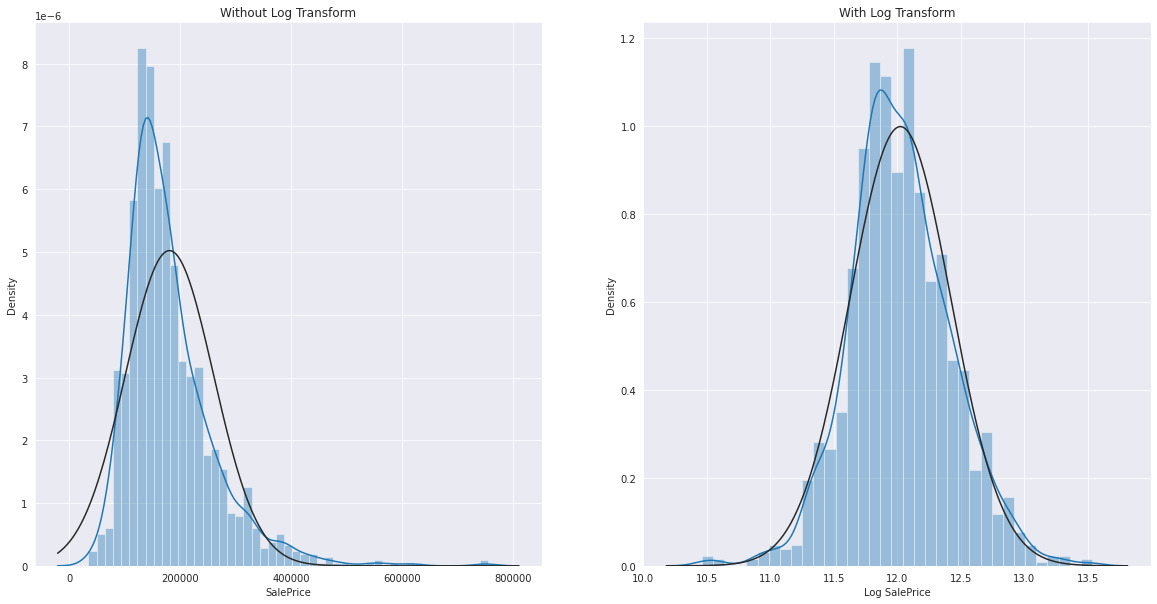

In [33]:
#Seaborn distplot is depreciated. However the fit variable lets us overlay a normal distribution to help visualize the differences.

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.distplot(target, kde=True, fit=stats.norm)
plt.title("Without Log Transform")

plt.subplot(1, 2, 2)
sns.distplot(np.log(target), kde=True, fit=stats.norm)
plt.xlabel("Log SalePrice")
plt.title("With Log Transform")

plt.show()

In [34]:
log_target = np.log(target)

# 3.3 Variable Transformation

Lets check the skew on the numeric variables.

We can often fix the skew in a variable by performing either a boxcox or yeojohnson transformation. We also can just use a logarithmic transformation. Here I will use np.log1p as that is equivalent to log(x+1) as log(0) is undefined, this will fix any issues. As we do not have any negative values this should work well.

It will not fix every variable but should be beneficial for prediction overall.

In [35]:

skew = []

for col in num_cols:
    skew.append(data3[col].skew())
    
skew_df = pd.DataFrame({"Feature": num_cols, "Skew": skew})
skew_df['AbsSkew'] = np.abs(skew_df['Skew'])
skew_df['Skewed'] = skew_df['AbsSkew'].apply(lambda x: True if x>= 0.5 else False)


data4 = data3.copy()
skew_df['AfterTransform'] = skew_df['Skew']
for col in skew_df[skew_df['Skewed'] == True]['Feature']:
    data4[col] = np.log1p(data4[col])
    skew_df.loc[skew_df['Feature'] == col,'AfterTransform'] = data4[col].skew()
    #data1.loc[(data1.MSZoning.isnull()) & (data1.Neighborhood == "IDOTRR"), "MSZoning"] = "RM"
skew_df

Feature       Skew    AbsSkew  Skewed  AfterTransform
0      LotFrontage   1.361334   1.361334    True       -0.933093
1          LotArea  12.829025  12.829025    True       -0.505010
2       MasVnrArea   2.614936   2.614936    True        0.537294
3       BsmtFinSF1   1.425963   1.425963    True       -0.616949
4       BsmtFinSF2   4.148275   4.148275    True        2.463749
5        BsmtUnfSF   0.919812   0.919812    True       -2.156314
6      TotalBsmtSF   1.157489   1.157489    True       -4.958842
7         1stFlrSF   1.470360   1.470360    True        0.064861
8         2ndFlrSF   0.862118   0.862118    True        0.305206
9     LowQualFinSF  12.094977  12.094977    True        8.562091
10       GrLivArea   1.270010   1.270010    True        0.013194
11     GarageYrBlt  -0.691071   0.691071    True       -0.716909
12      GarageArea   0.241020   0.241020   False        0.241020
13      WoodDeckSF   1.843380   1.843380    True        0.158114
14     OpenPorchSF   2.536417   2.536417    True       -0.041819
15   EnclosedPorch   4.005950   4.005950    True        1.962089
16       3SsnPorch  11.381914  11.381914    True        8.829794
17     ScreenPorch   3.948723   3.948723    True        2.947420
18         MiscVal  21.958480  21.958480    True        5.216665
19        BuildAge   0.598958   0.598958    True       -0.816647
20      RemodelAge   0.450630   0.450630   False        0.450630
21     SqftPerRoom   0.894451   0.894451    True        0.201255
22      HighQualSF   1.252679   1.252679    True        0.001332
23      TotalPorch   1.377357   1.377357    True       -1.358405
24    BsmtFullBath   0.625153   0.625153    True        0.425385
25    BsmtHalfBath   3.933616   3.933616    True        3.776703
26        FullBath   0.167692   0.167692   False        0.167692
27        HalfBath   0.694924   0.694924    True        0.580990
28    BedroomAbvGr   0.326492   0.326492   False        0.326492
29    KitchenAbvGr   4.304467   4.304467    True        3.522161
30    TotRmsAbvGrd   0.758757   0.758757    True        0.035125
31      Fireplaces   0.733872   0.733872    True        0.237710
32      GarageCars  -0.218705   0.218705   False       -0.218705
33          MoSold   0.195985   0.195985   False        0.195985
34          YrSold   0.132467   0.132467   False        0.132467
35  TotalBathrooms   0.492500   0.492500   False        0.492500
36        PoolArea  16.907017  16.907017    True       15.006047

One of our variables is cyclical. That is MoSold. This value ranges from 1-12 however 1 and 12 are actually closer than say 1 and 6 due to the cyclical nature of months. We can map this using a sin/cos transformation. 

We essentially want to create function $cos(k\cdot month)$ where we have a single period with highs at 1 and 12 and a low at 6. This can be done with simple transformations on $cos(x)$.

$cos(x - 1)$ will shift the period over by 1, giving us a maximum at 1. Then as cosine has a period length of $2\pi$ we can multiply by $2\pi$, then divide by 12 to give it a period of 12. or $\frac{\pi}{6}$

$cos(\frac{\pi}{6}(x-1))$


In [36]:
data4['MoSold'] = np.cos((np.pi/6)*data4['MoSold']- 1)

# 3.4 Bivariate Analysis/ Visualization

We can take a look at some visualizations for our variable in order to help us with feature selection if desired. We need to put our target back into the dataframe.

In [37]:
train1 = pd.concat([data4.loc[:train0.index.max(),:],log_target], axis = 1)

In [38]:
def bar_box(df, col, target):
    
    sns.set_style("darkgrid")
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex = True)
    
    order = sorted(df[col].unique())
    
    sns.countplot(data = df, x = col, ax = axes[0], order = order)      
    sns.boxplot(data = df, x = col, ax = axes[1], y = target, order = order)
    
    fig.suptitle("For Feature:  " + col)
    axes[0].set_title("In DataFrame")
    axes[1].set_title(col + " --- " + target)
    
    for ax in fig.axes:
        plt.sca(ax)
        plt.xticks(rotation=90)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


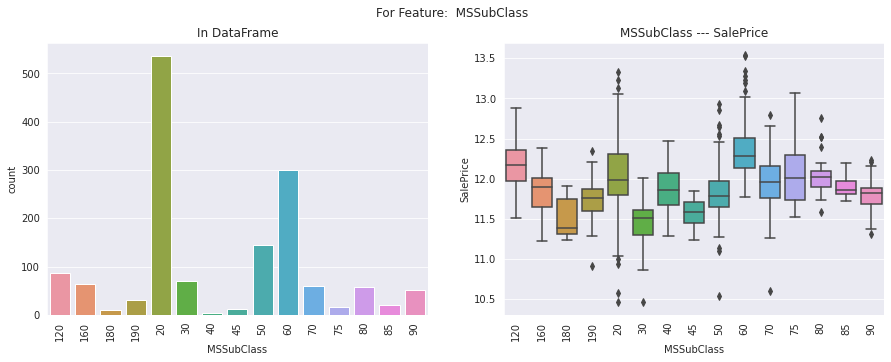

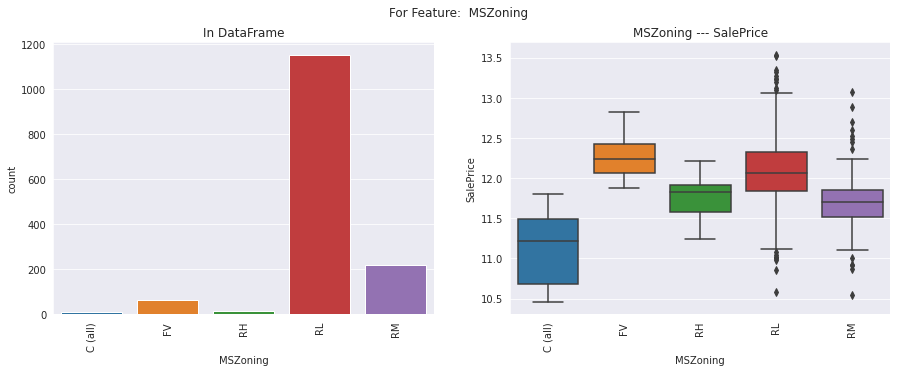

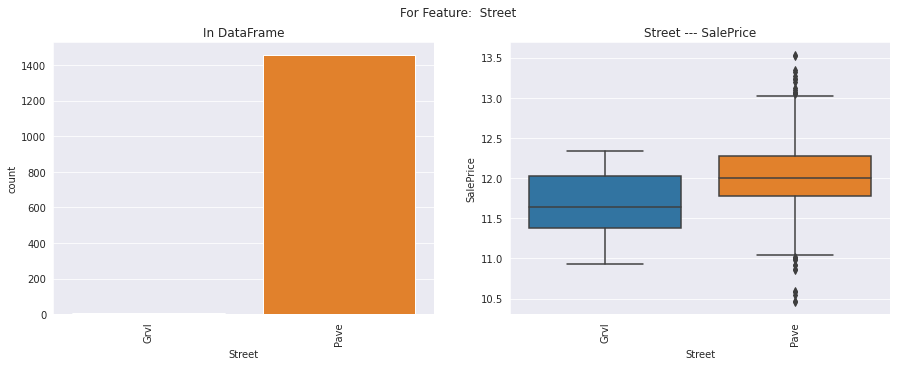

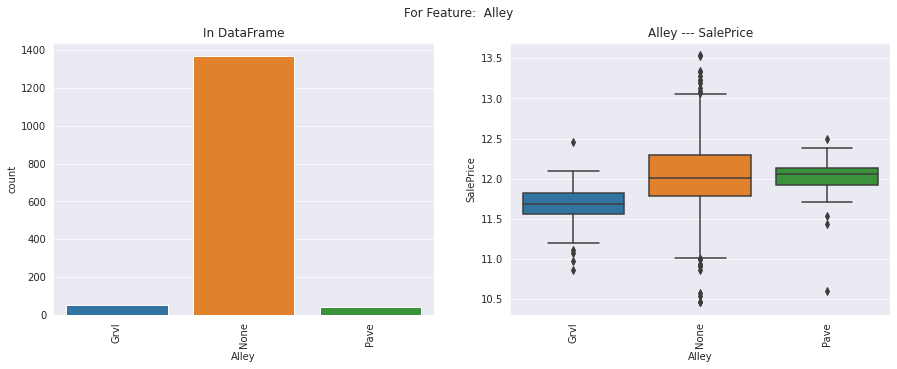

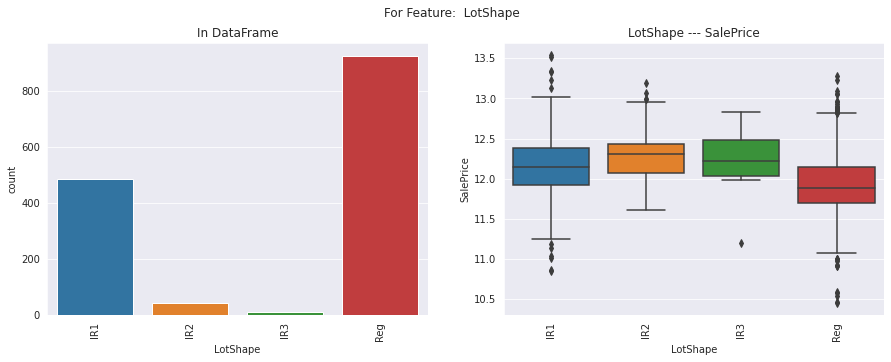

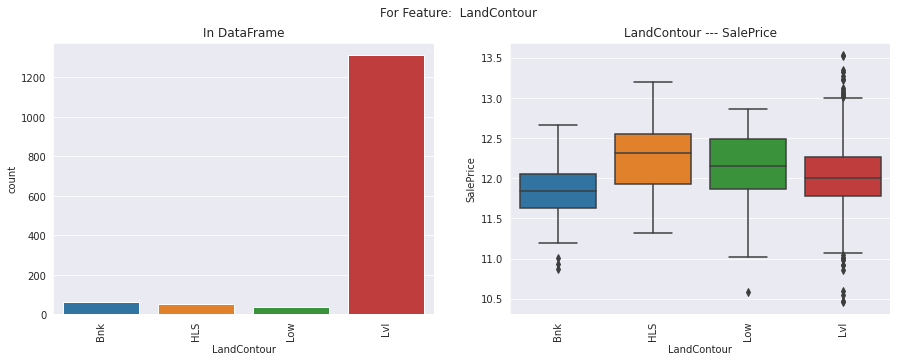

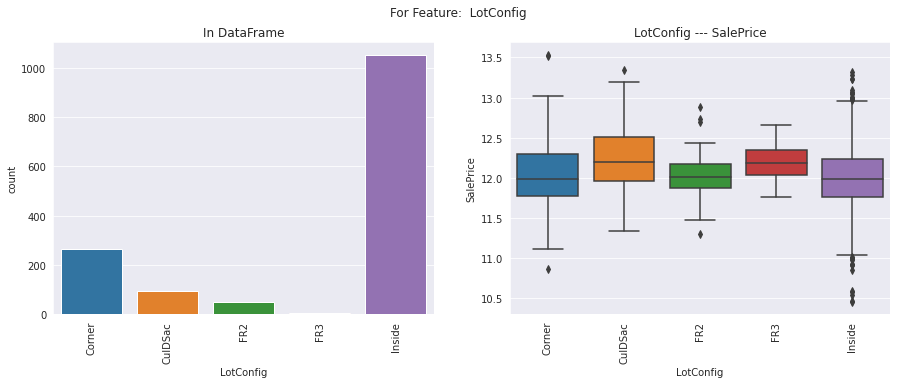

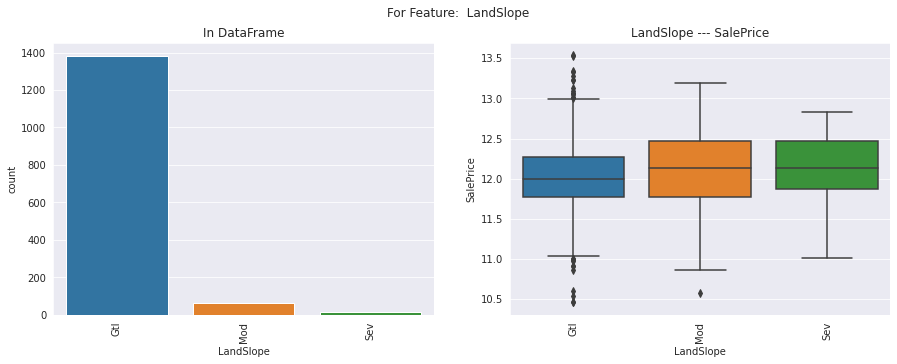

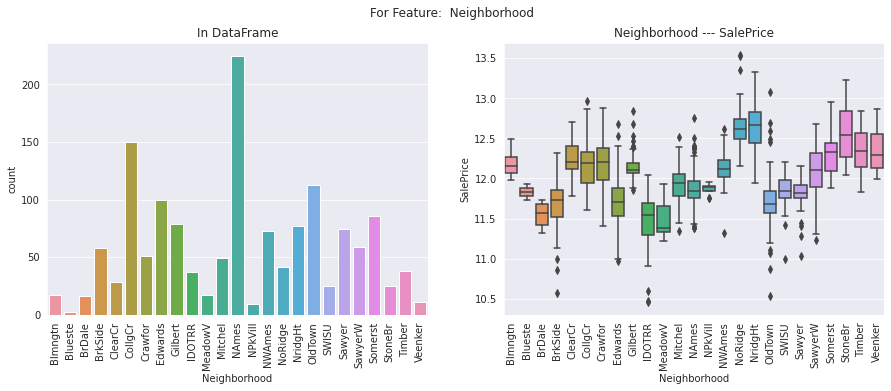

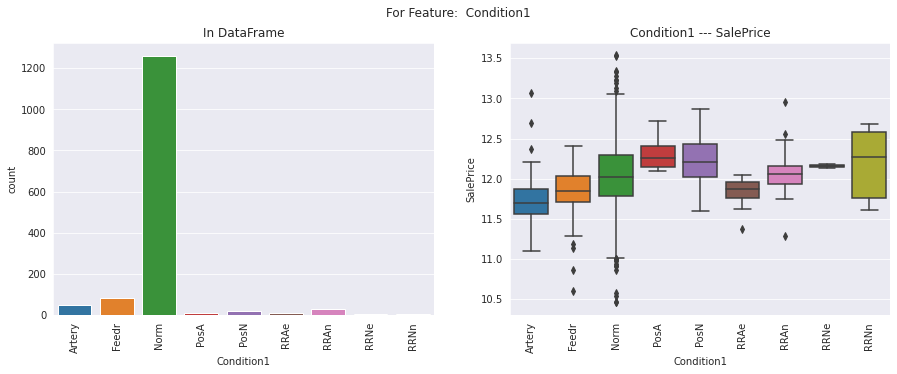

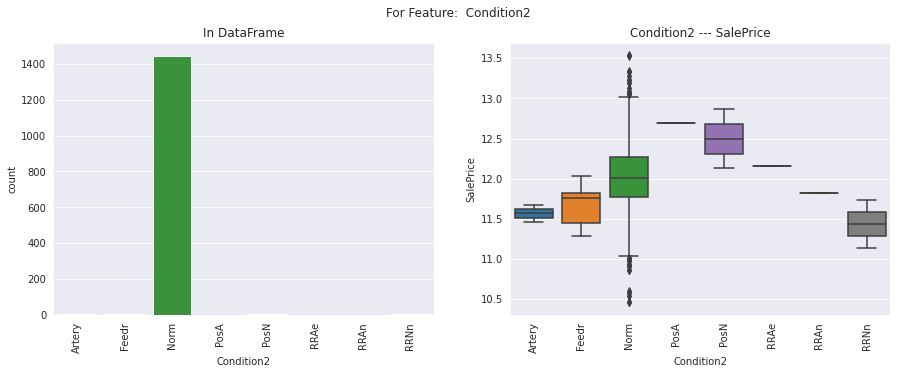

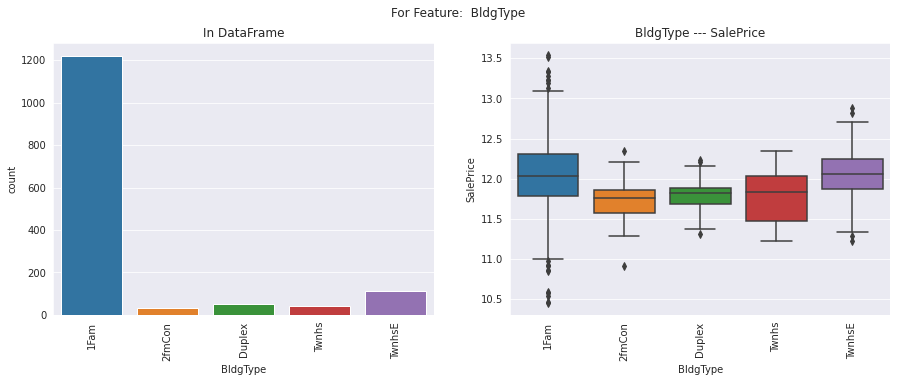

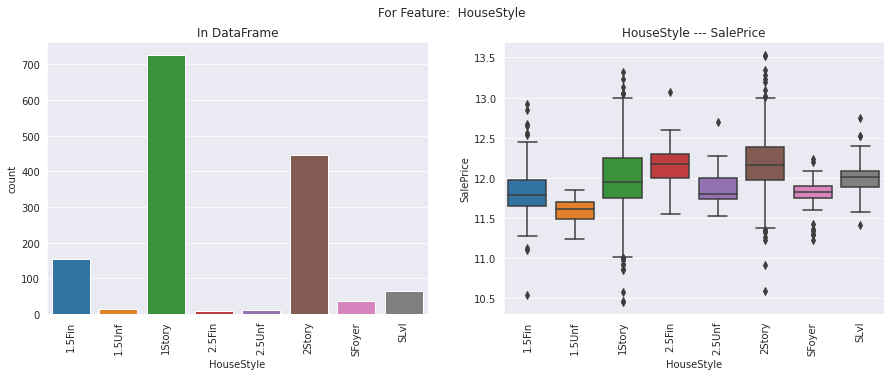

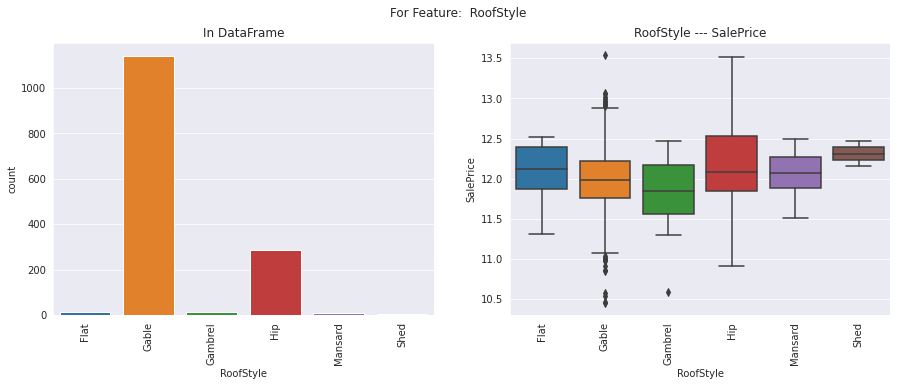

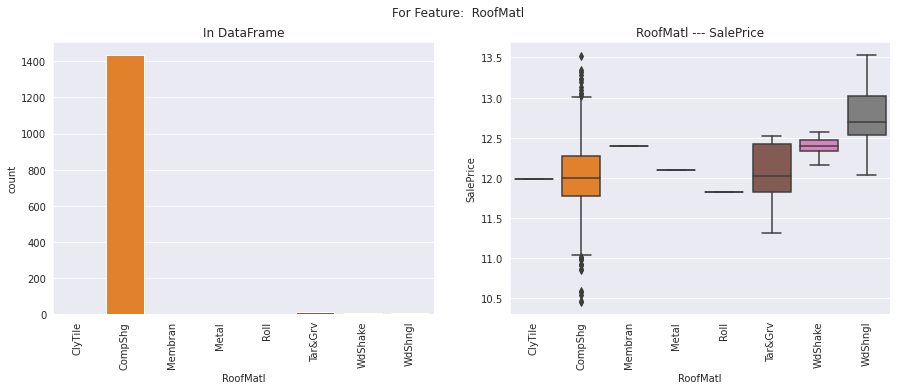

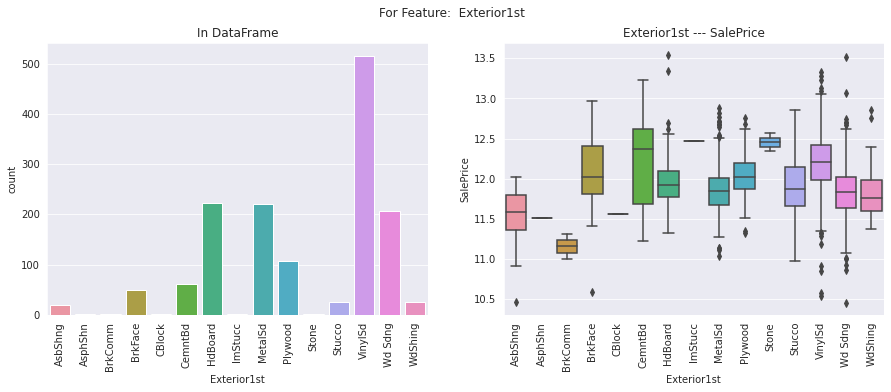

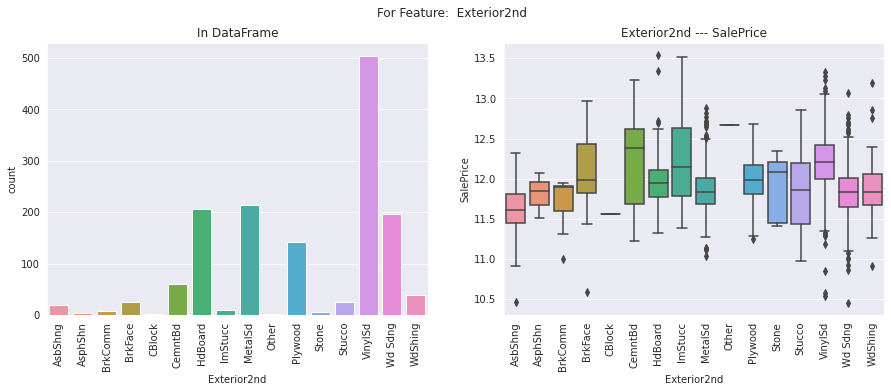

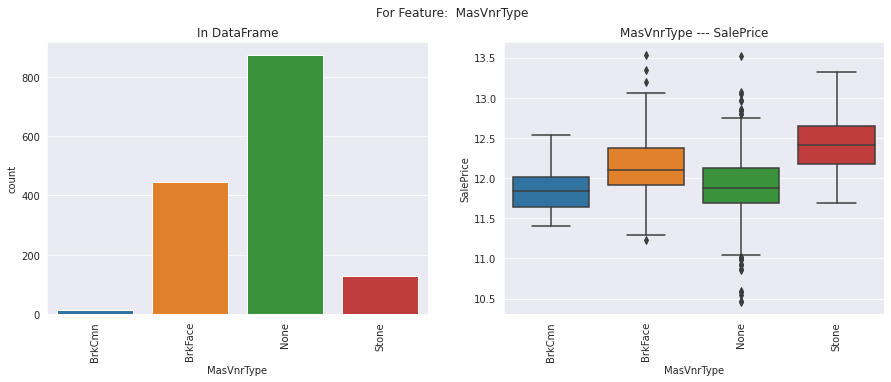

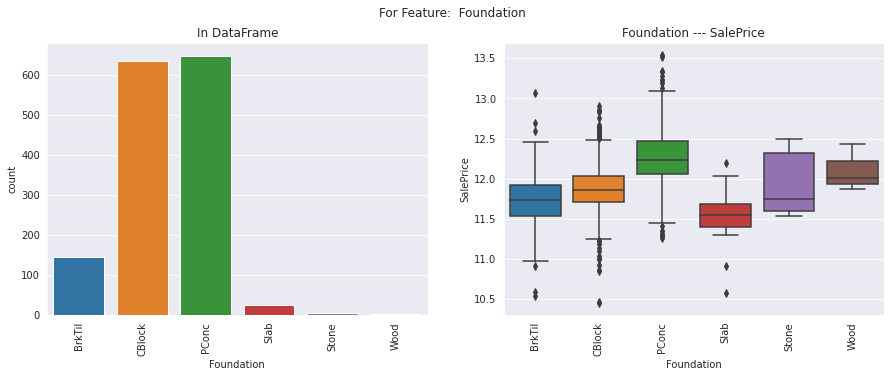

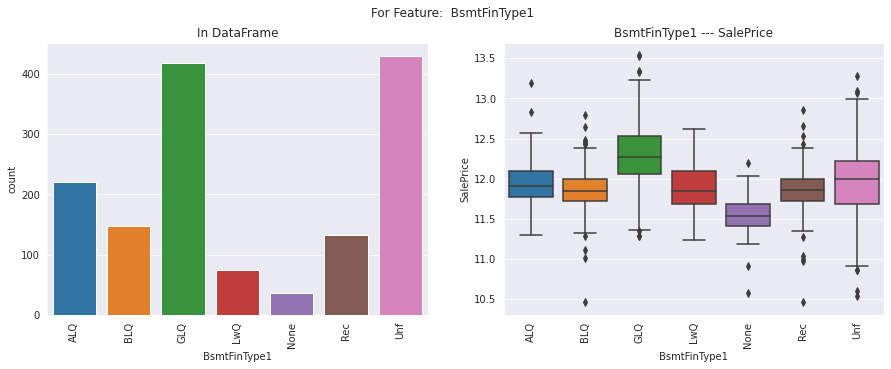

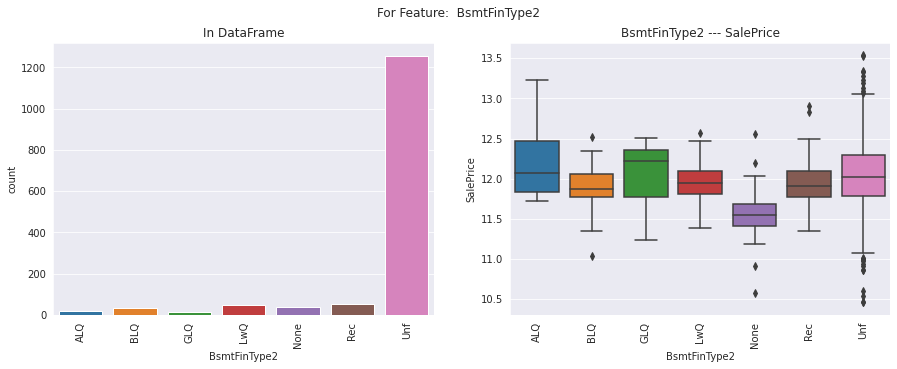

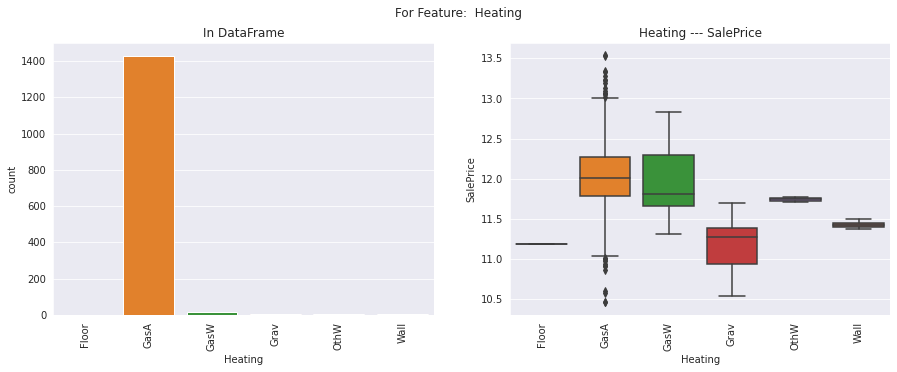

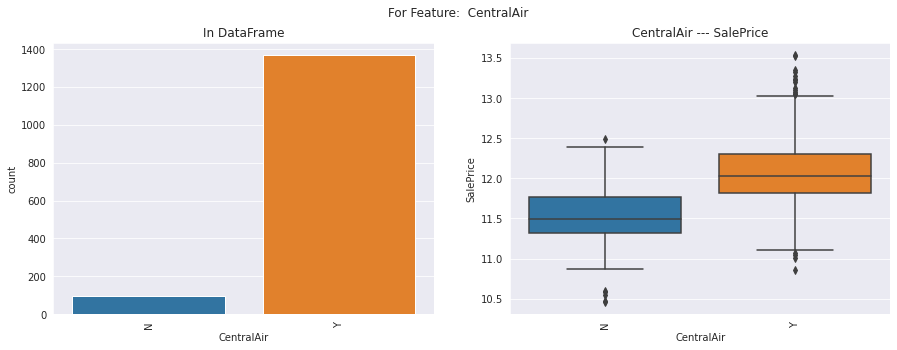

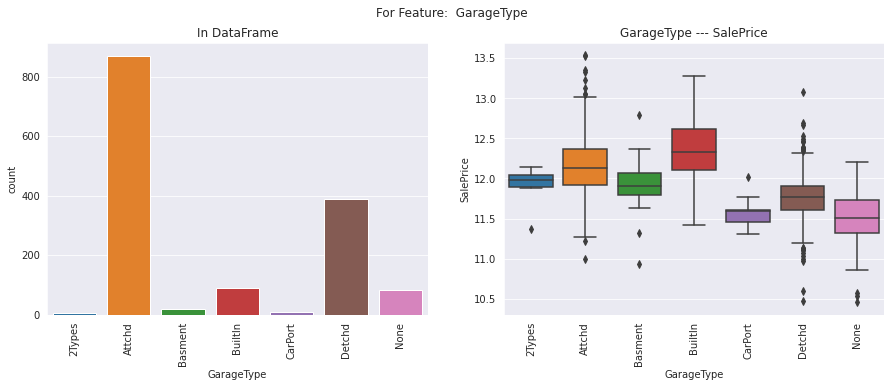

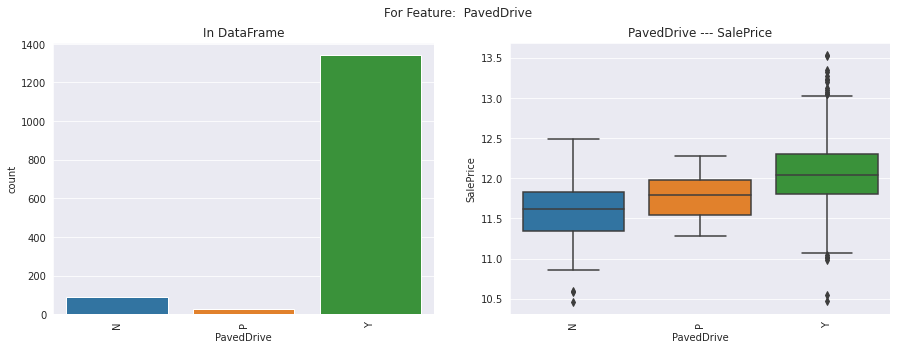

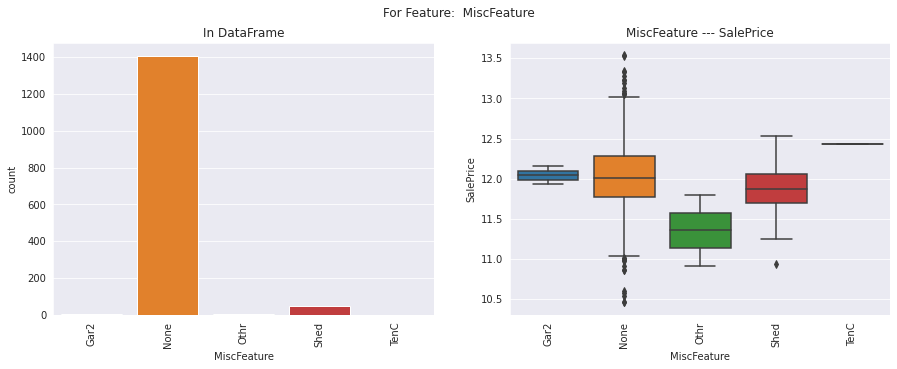

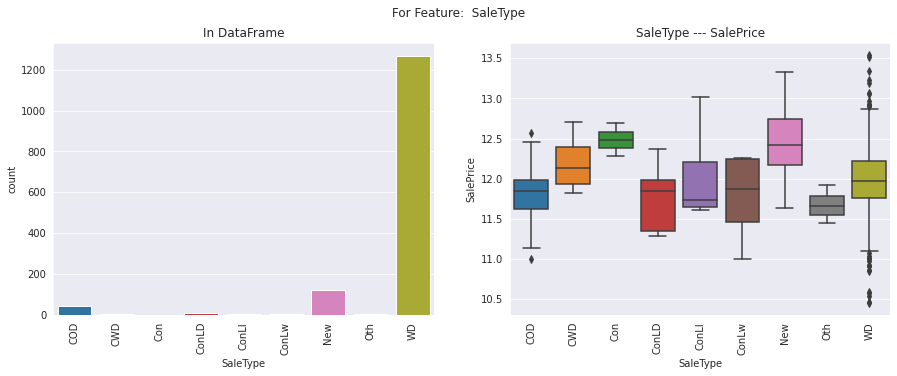

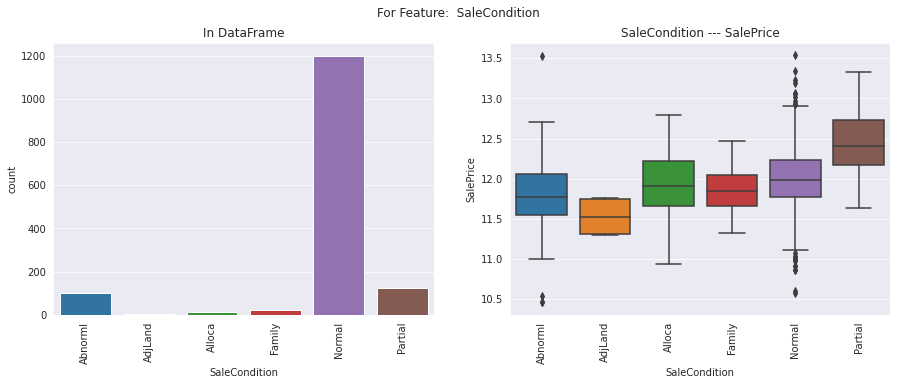

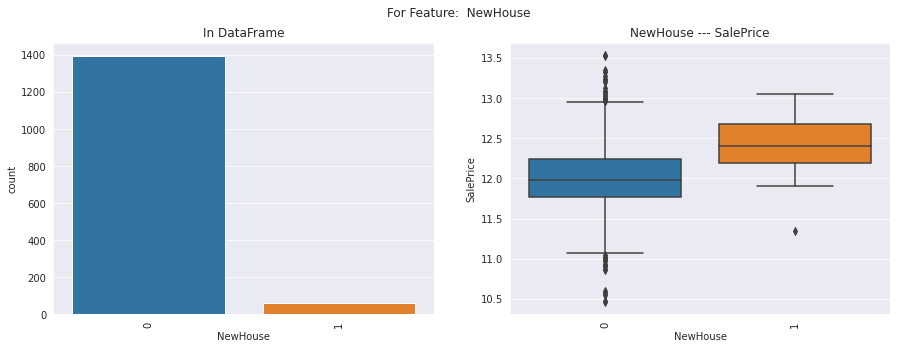

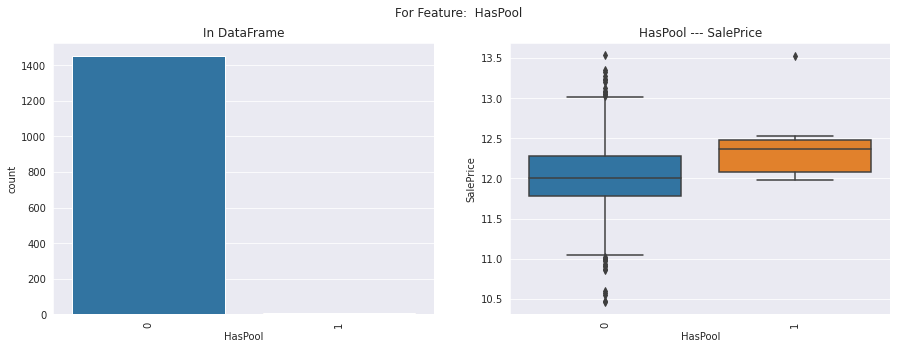

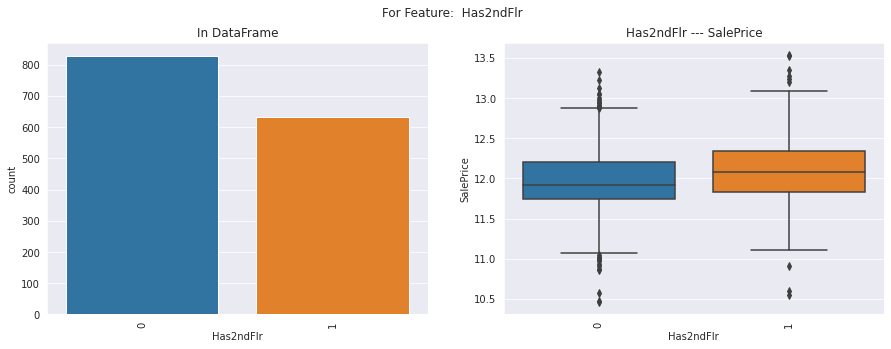

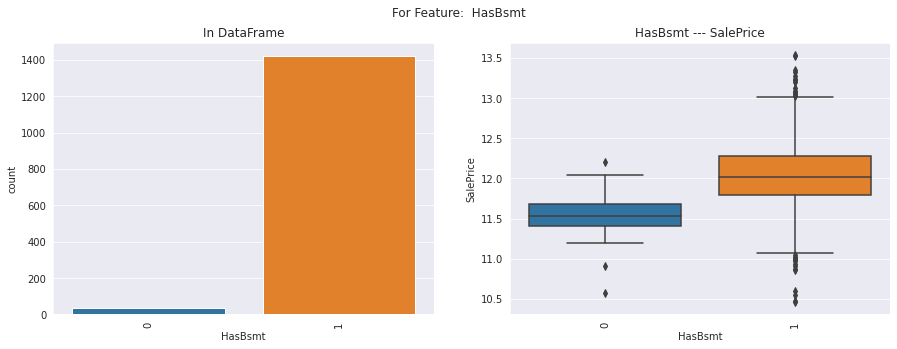

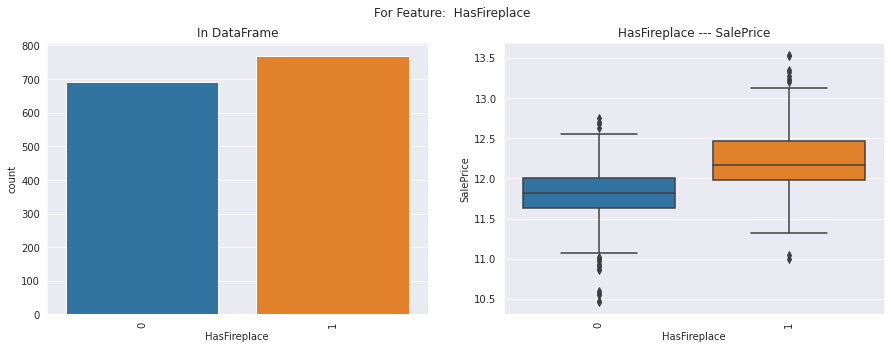

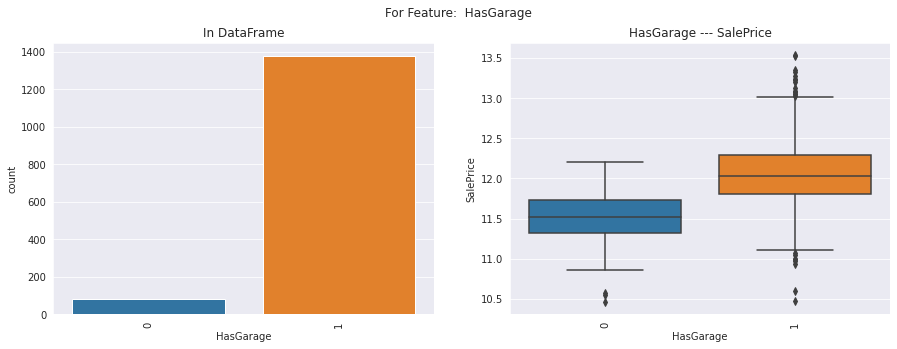

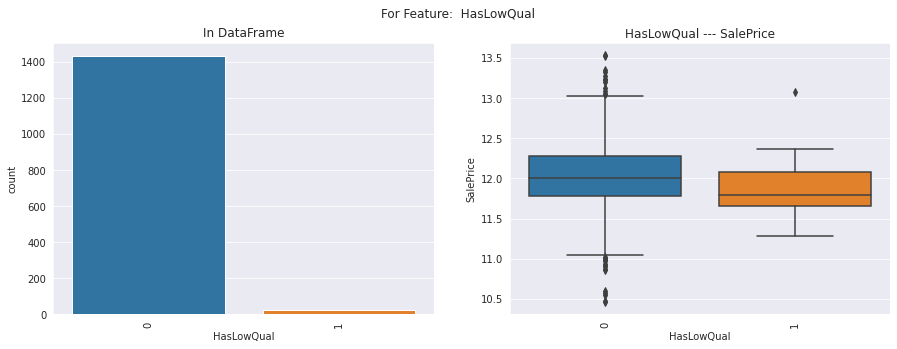

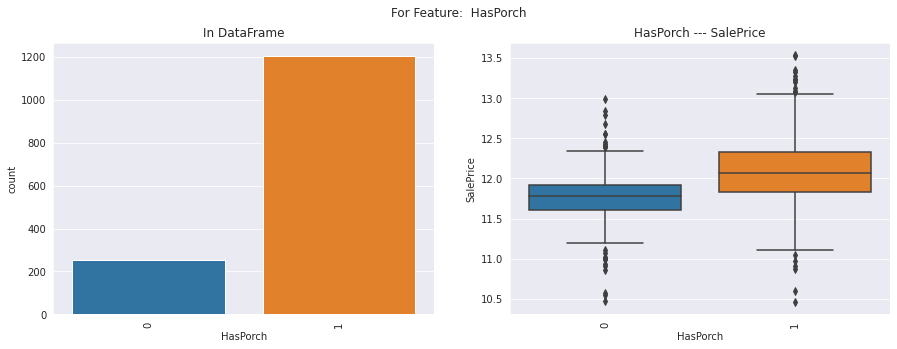

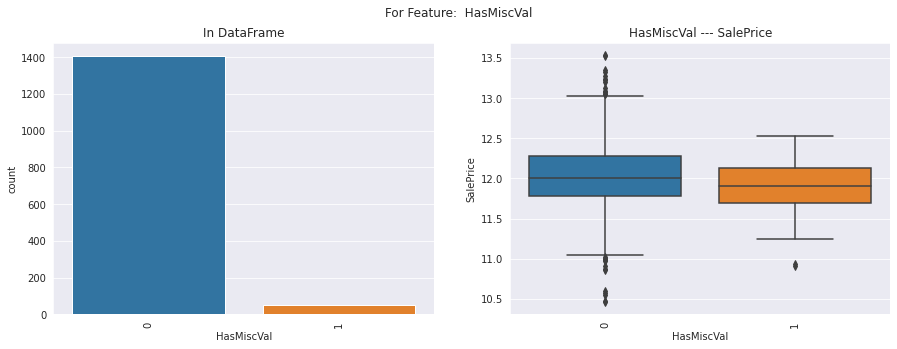

In [39]:
for col in cat_cols:
    bar_box(train1, col, 'SalePrice')

In [40]:
def plot_scatter(df, col, target):
    sns.set_style("darkgrid")
    
    corr = df[[col, target]].corr()[col][1]    
    c = ["red"] if corr >= 0.7 else (["brown"] if corr >= 0.3 else\
                                    (["lightcoral"] if corr >= 0 else\
                                    (["blue"] if corr <= -0.7 else\
                                    (["royalblue"] if corr <= -0.3 else ["lightskyblue"]))))    

    fig, ax = plt.subplots(figsize = (5, 5))
    
    sns.scatterplot(x = col, y = target, data = df, c = c, ax = ax)        
    ax.set_title("Correlation between " + col + " and " + target + " is: " + str(corr.round(4)))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


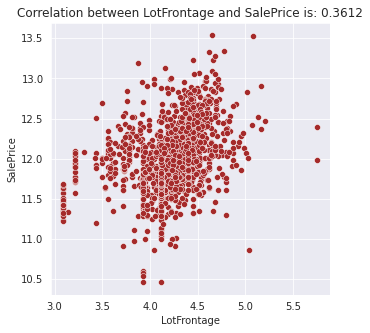

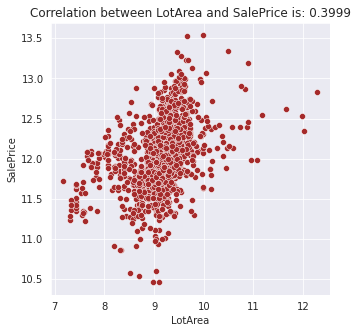

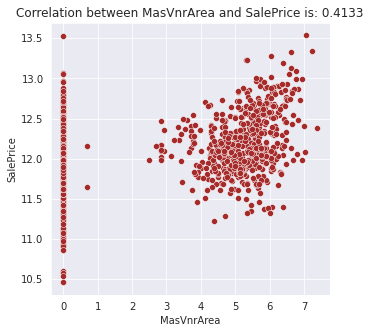

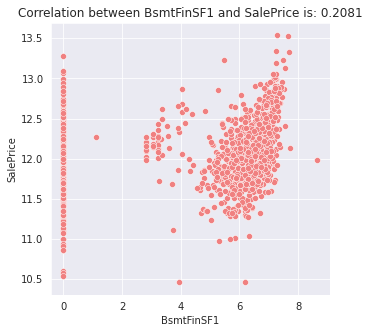

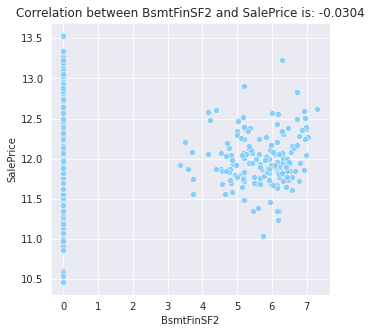

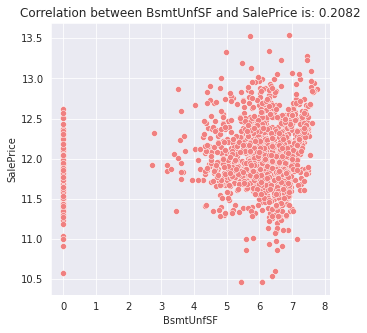

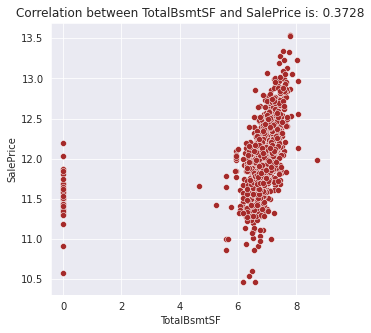

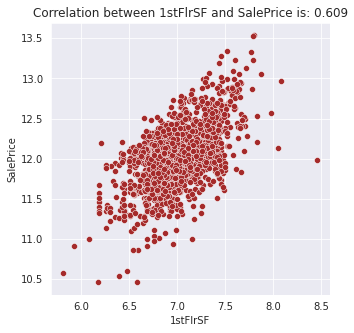

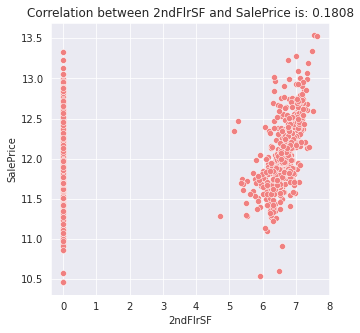

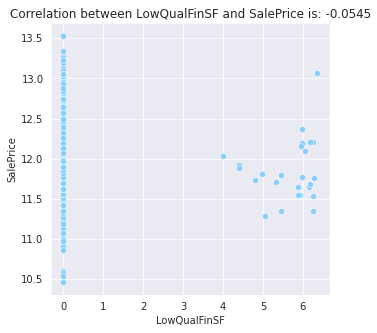

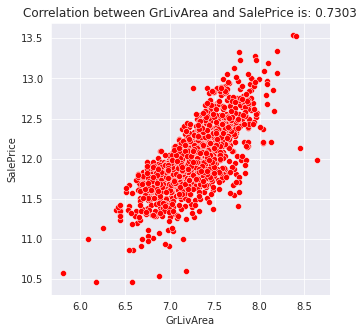

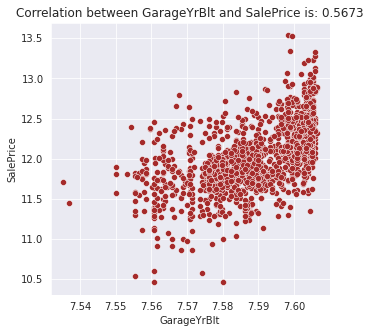

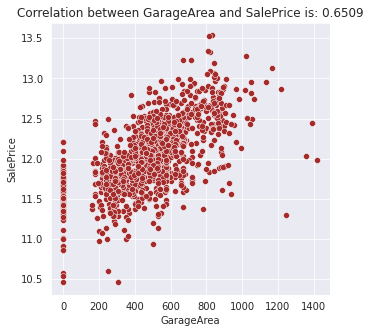

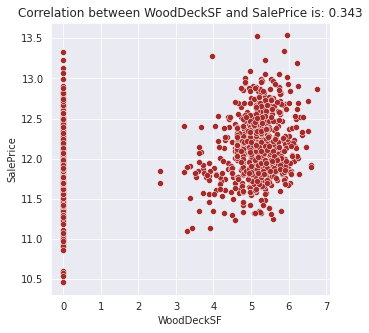

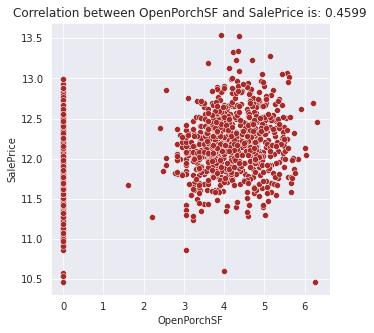

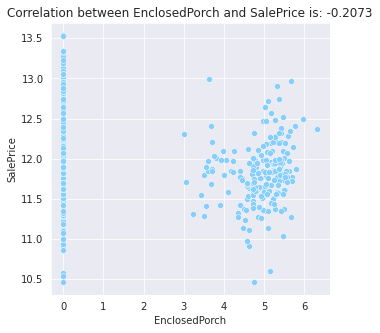

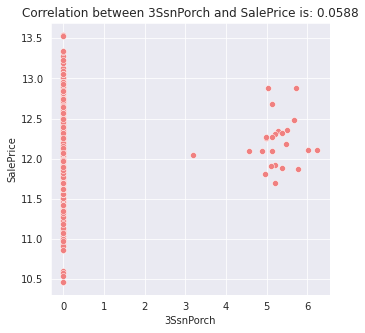

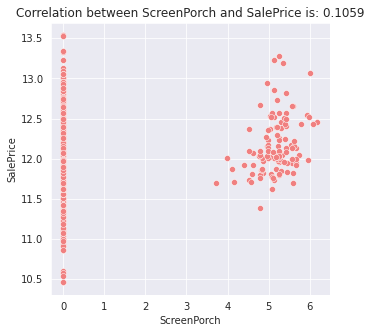

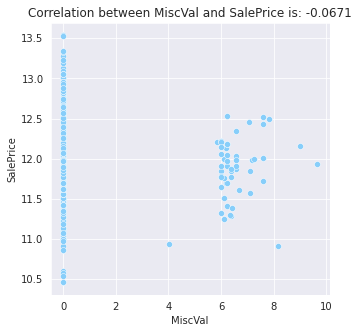

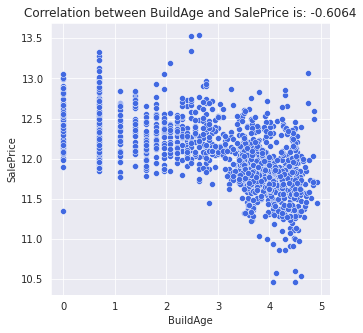

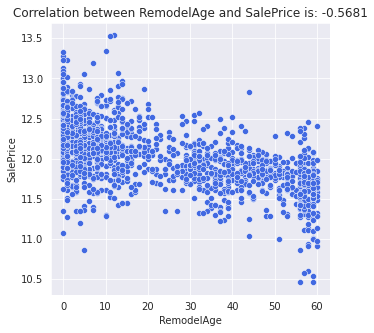

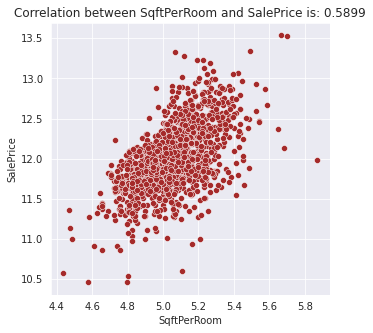

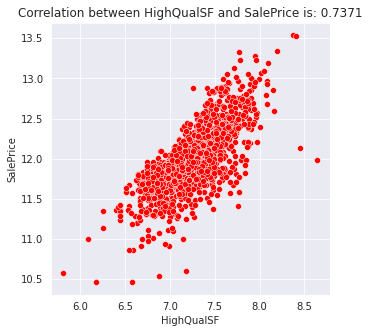

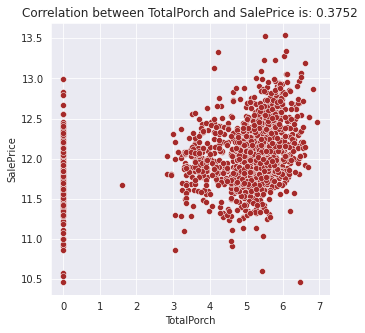

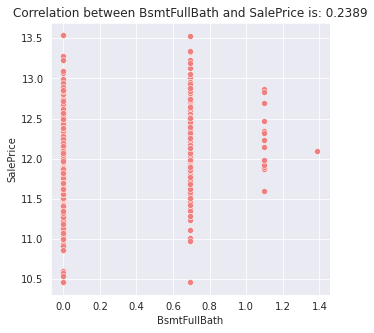

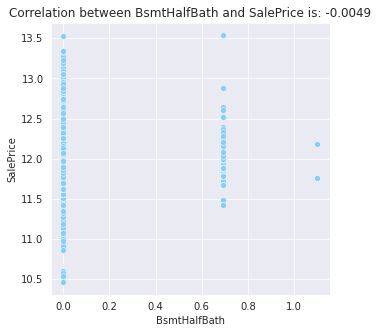

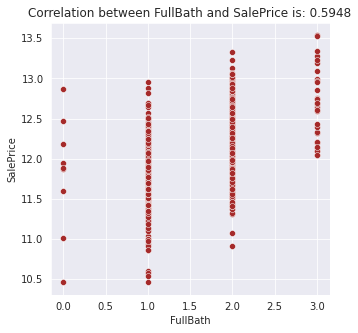

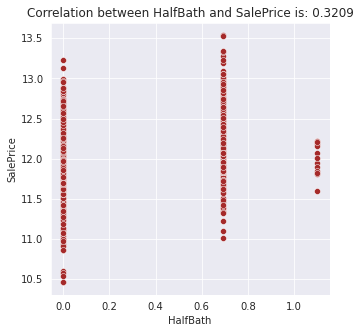

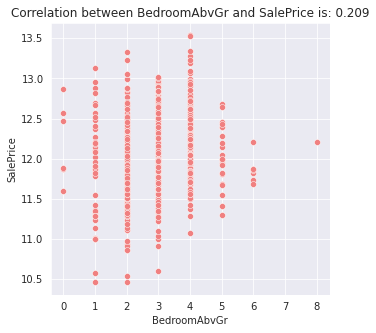

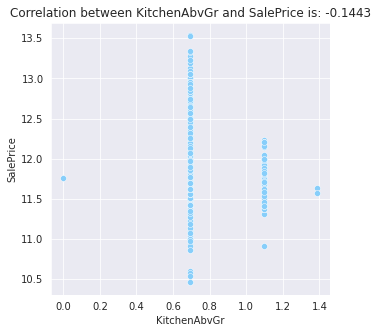

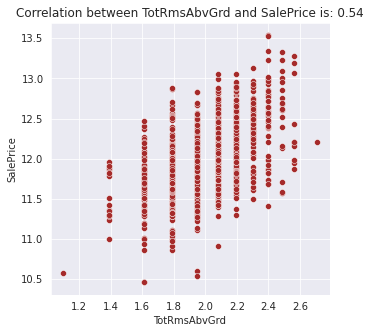

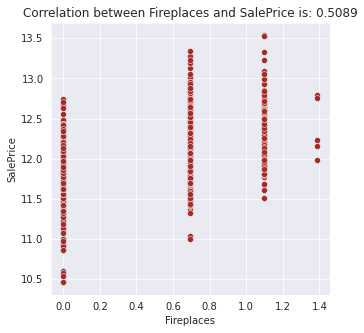

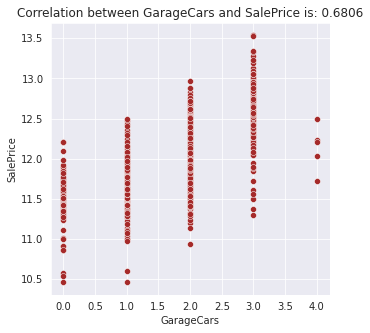

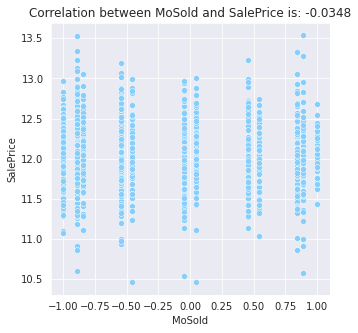

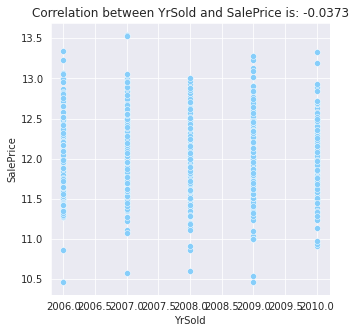

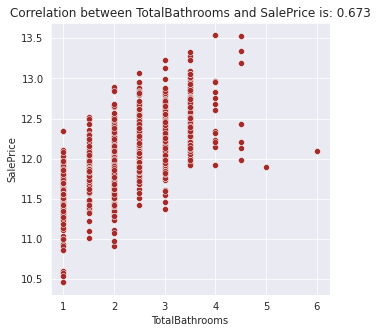

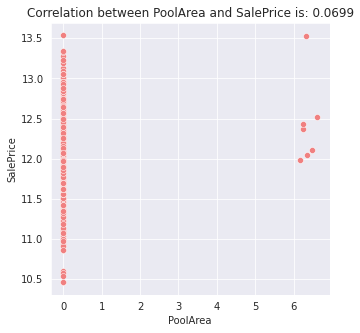

In [41]:
for col in num_cols:
    plot_scatter(train1,col,'SalePrice')

In [42]:
def feature_distribution(df, col, target, test = True):
    sns.set_style("darkgrid")
    if test == True:
        fig, axes = plt.subplots(1, 3, figsize=(25, 5))

        sns.kdeplot(data = df, x = col, fill=True, label = "train1", ax = axes[0], color = "orangered")
        
        axes[0].set_title("Distribution")
        axes[0].legend(loc = "best")
        
        sns.boxplot(data = df, y = col, ax = axes[1], color = "orangered")
        set_ylim(axes[1].get_ylim())        
        axes[1].set_title("Boxplot For Train Data")
    
        stats.probplot(df[col], plot = axes[2])
        
        stats.probplot(df[col], plot = axes[3])
        set_ylim(axes[3].get_ylim())        
        axes[3].set_title("Probability Plot For Train data")
        fig.suptitle("For Feature:  " + col)
    else:
        fig, axes = plt.subplots(1, 3, figsize = (18, 6))
        
        sns.kdeplot(data = df, x = col, fill = True, ax = axes[0], color = "orangered")
        sns.boxplot(data = df, y = col, ax = axes[1], color = "orangered")
        stats.probplot(df[col], plot = axes[2])
        
        axes[0].set_title("Distribution")
        axes[1].set_title("Boxplot")
        axes[2].set_title("Probability Plot")
        fig.suptitle("For Feature:  " + col)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


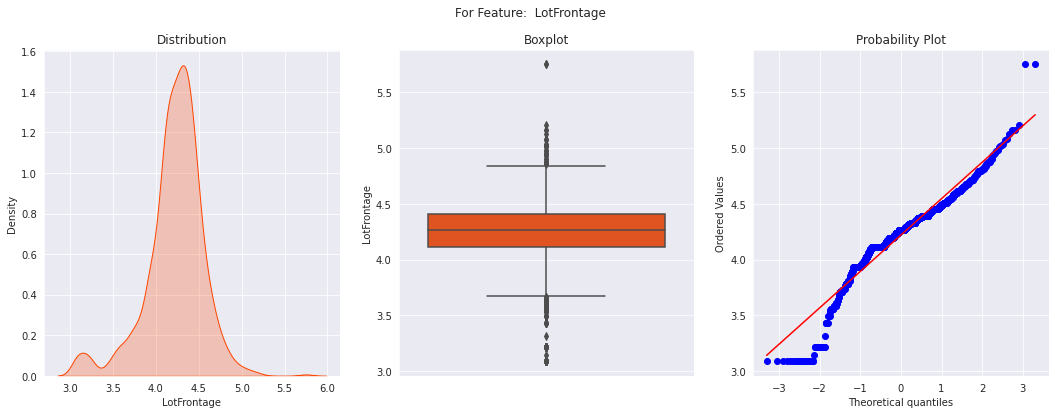

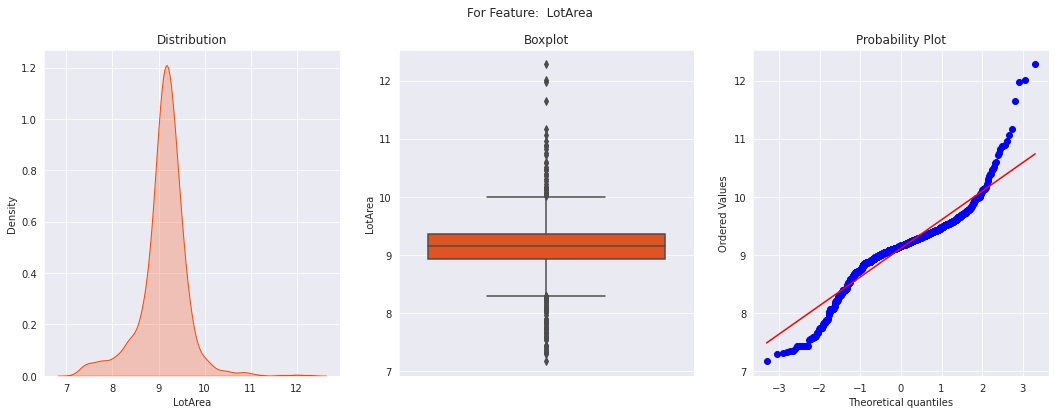

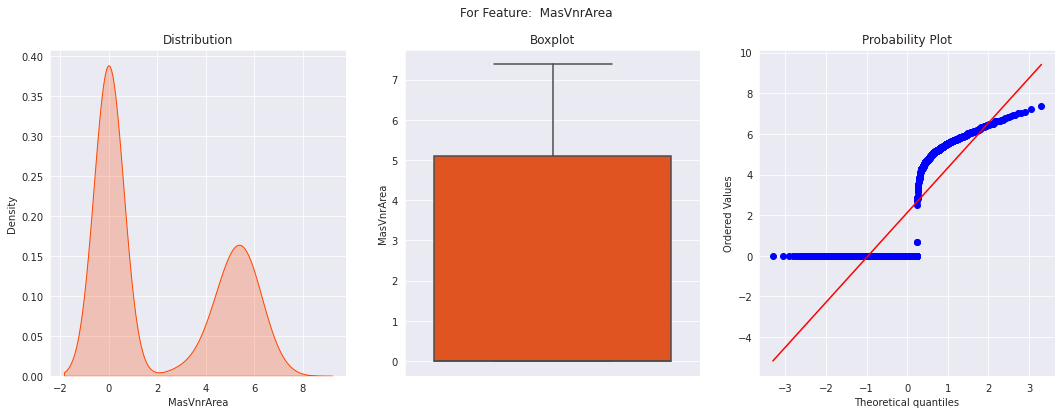

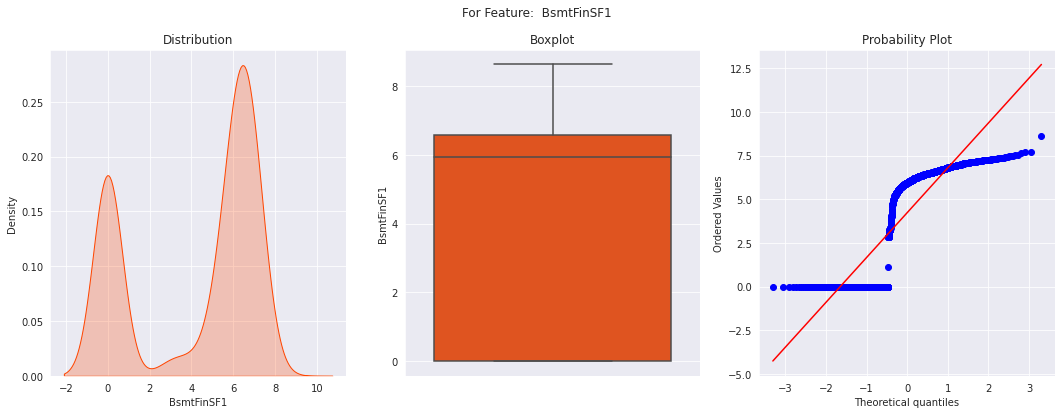

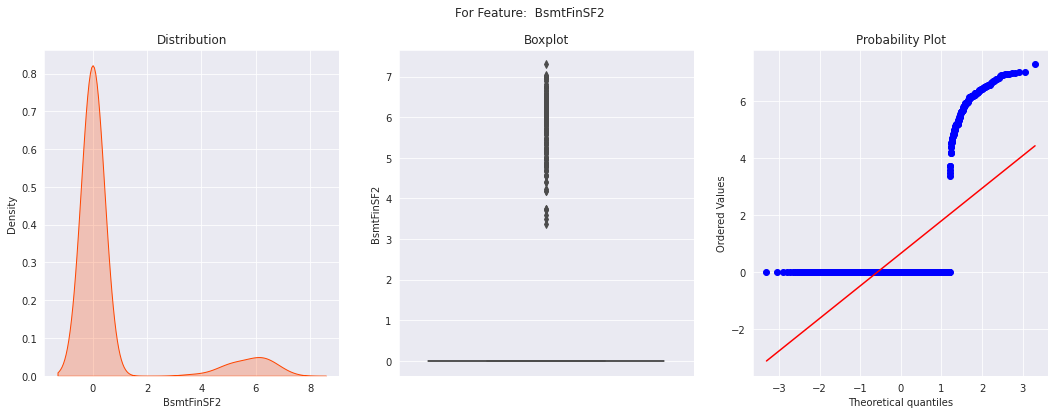

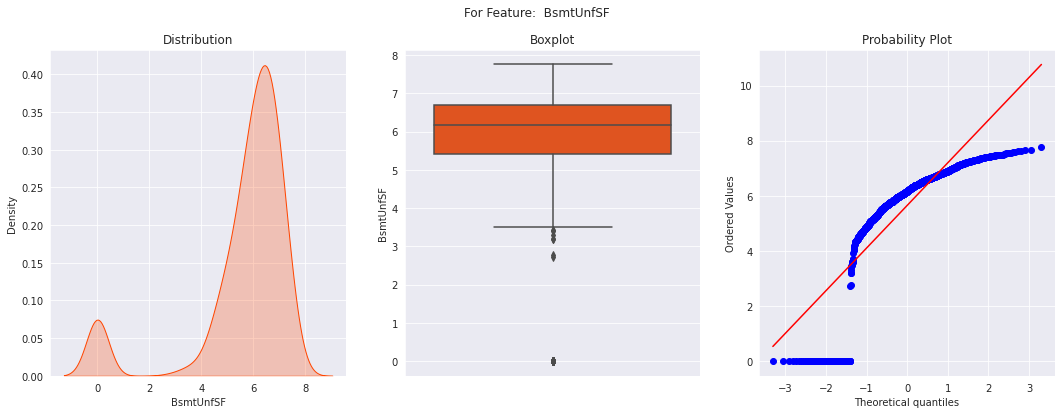

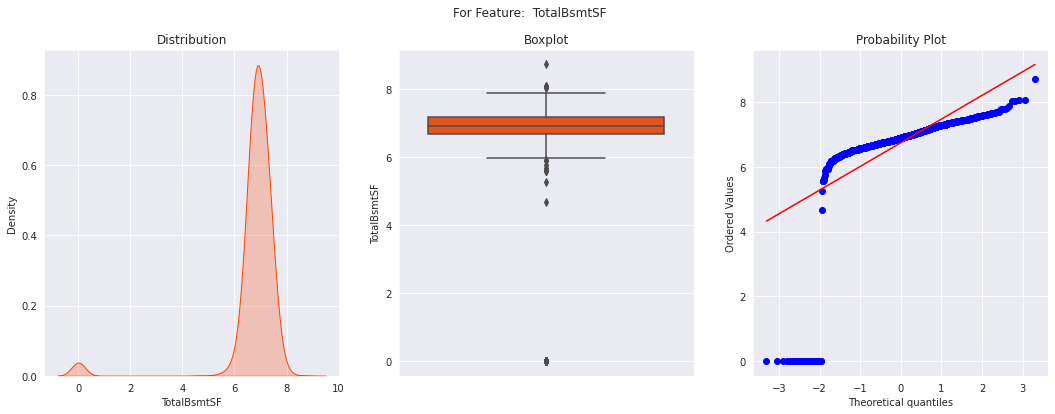

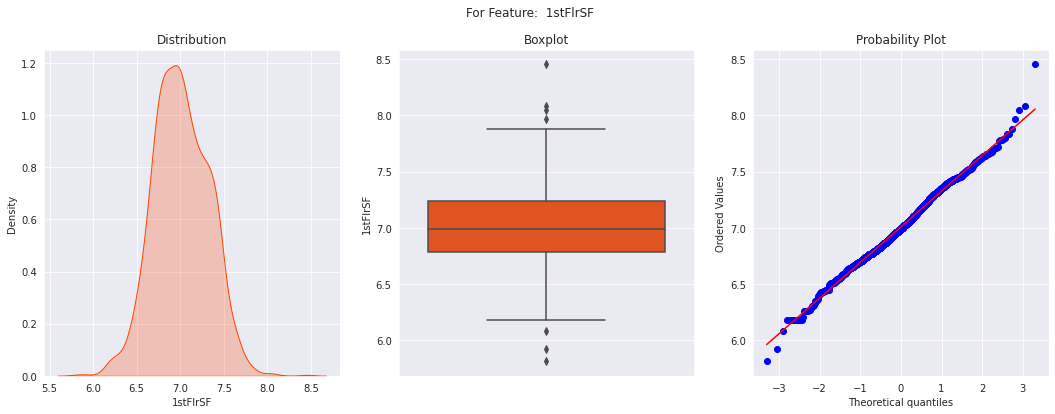

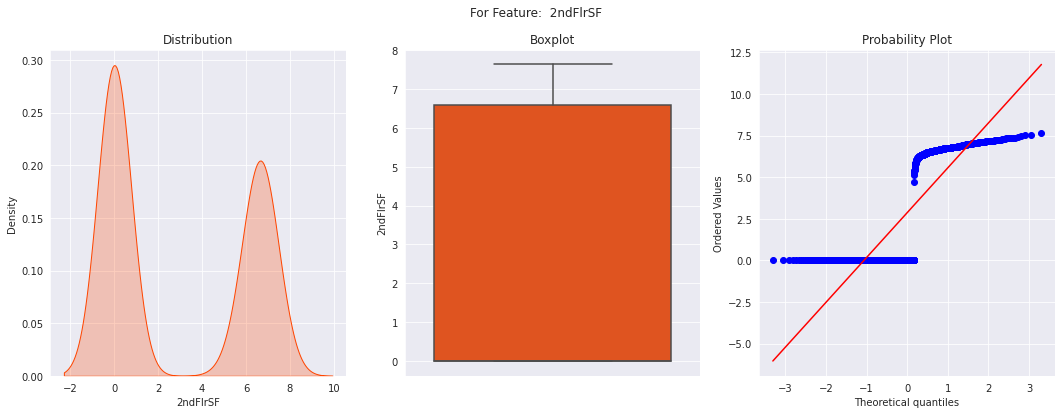

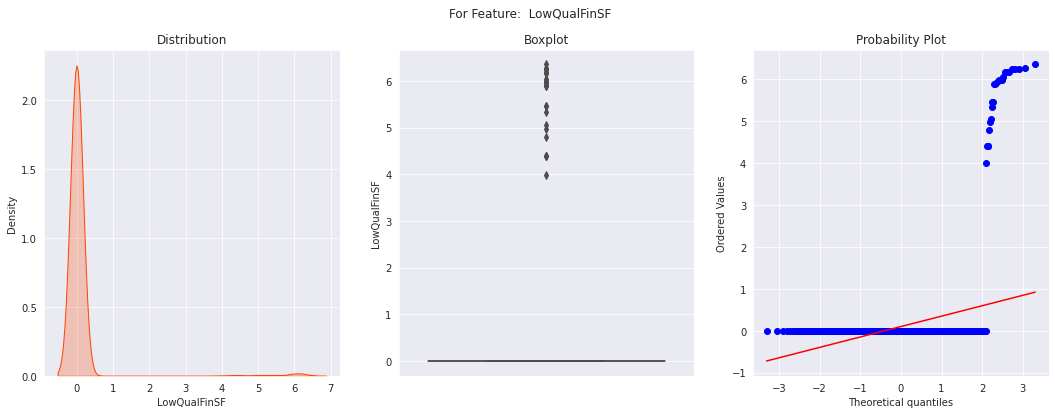

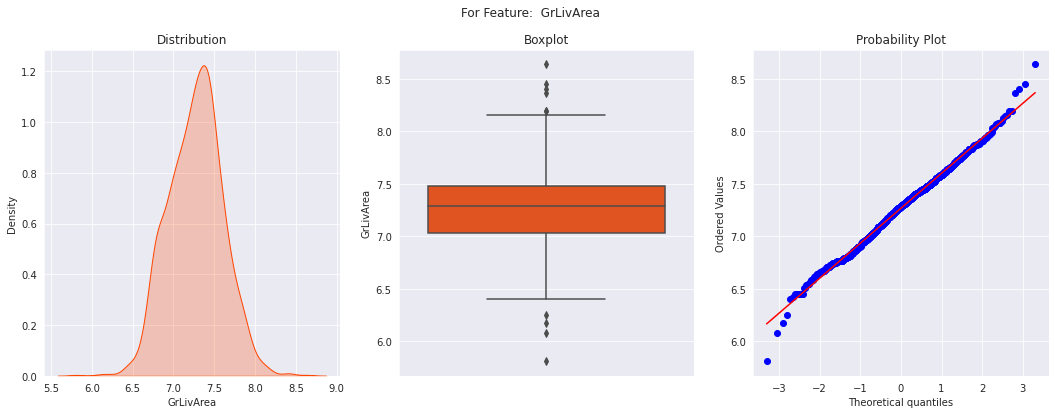

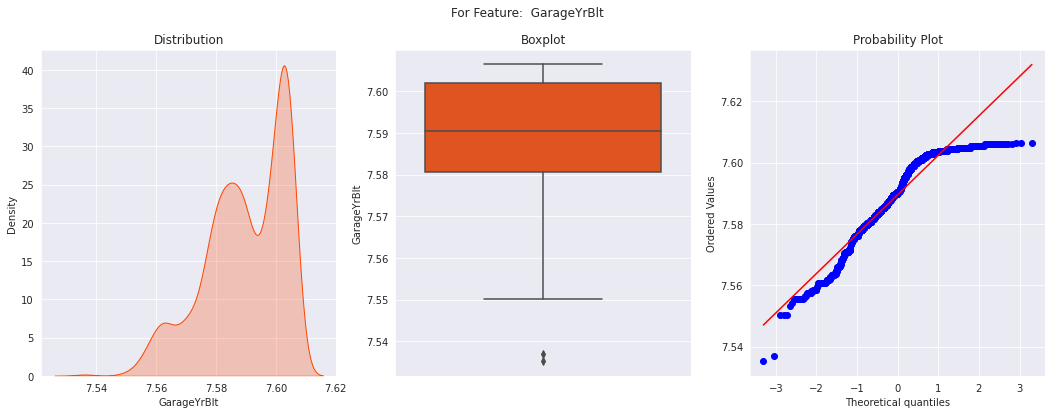

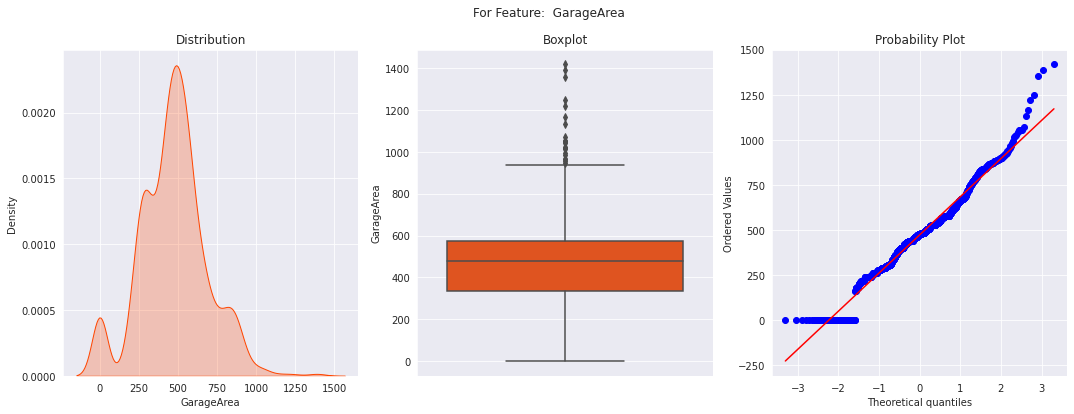

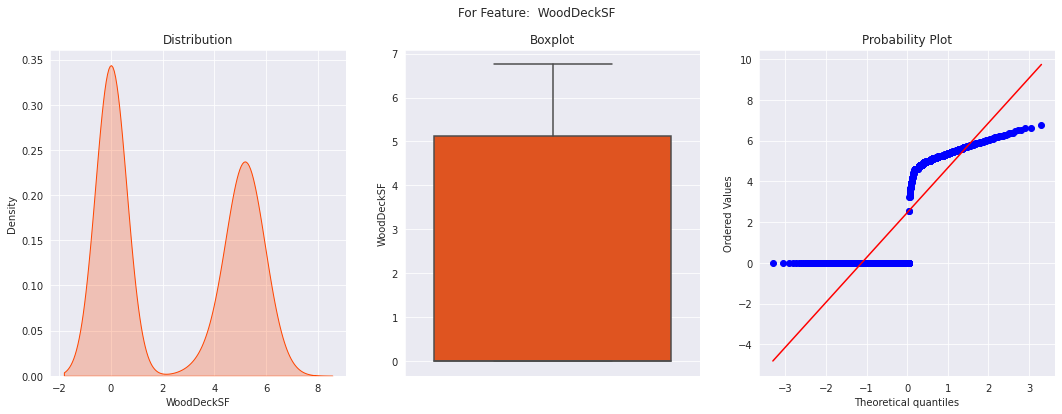

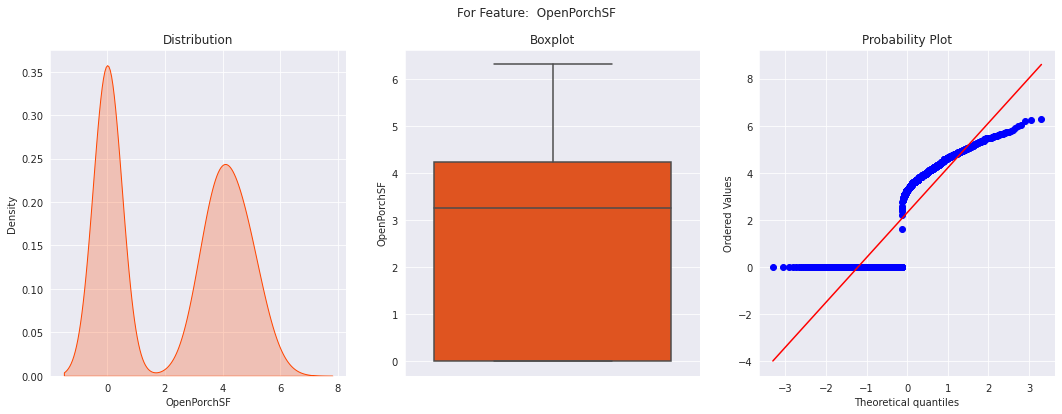

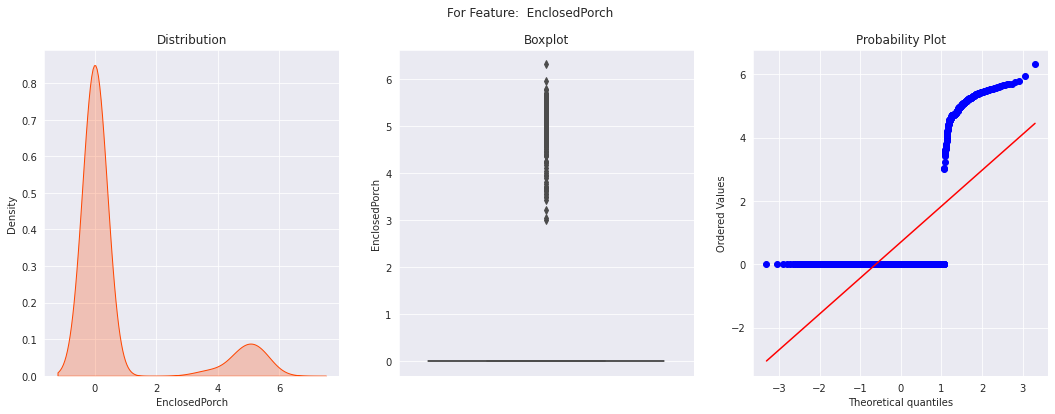

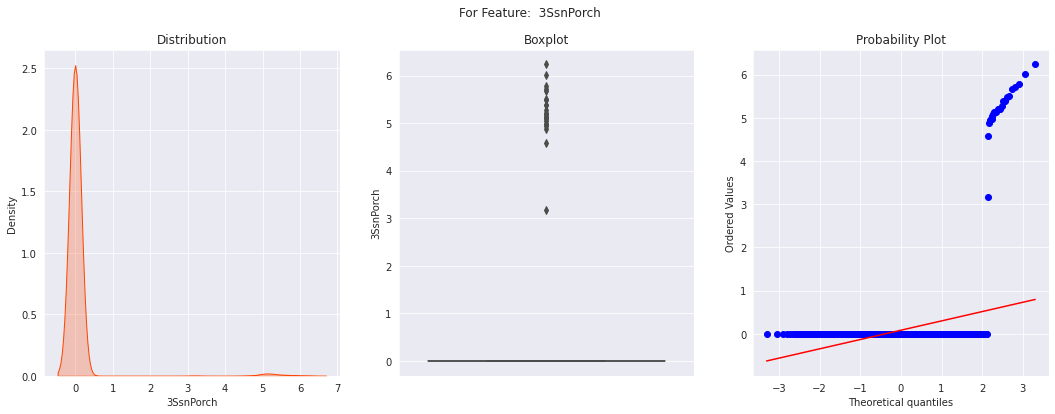

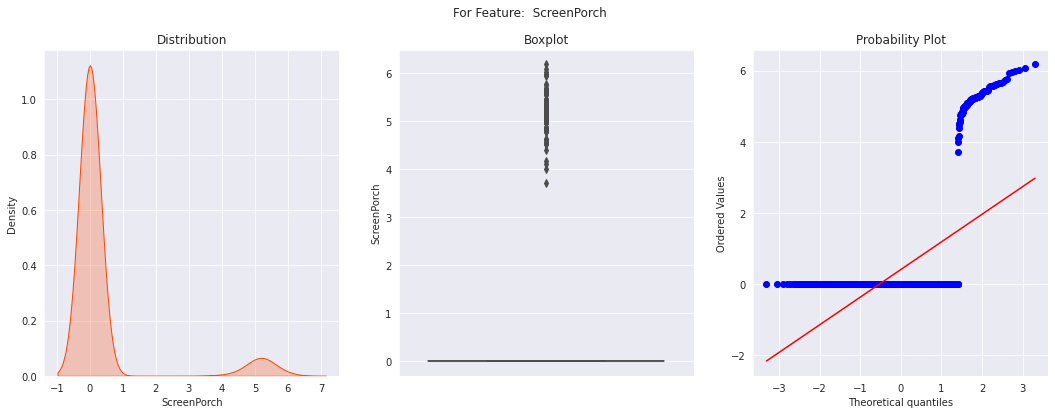

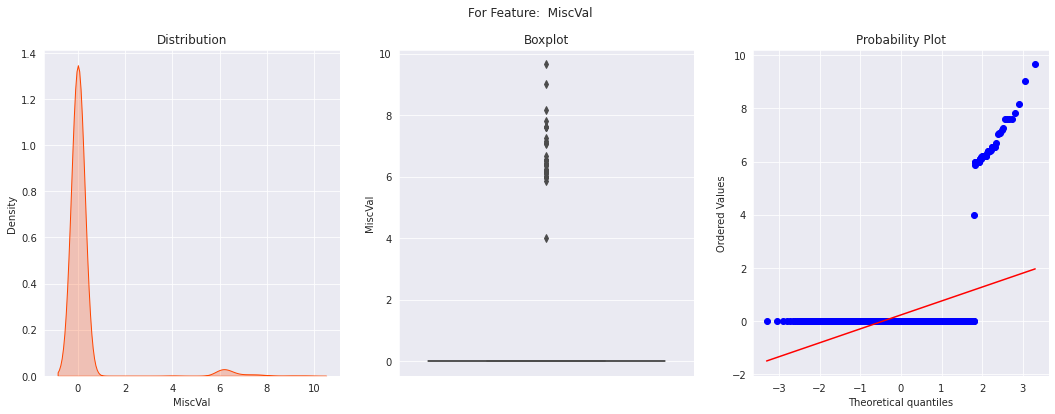

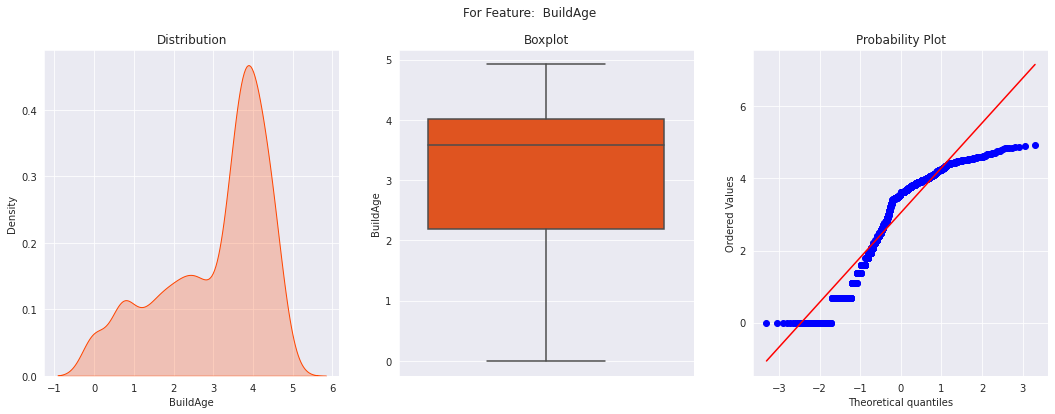

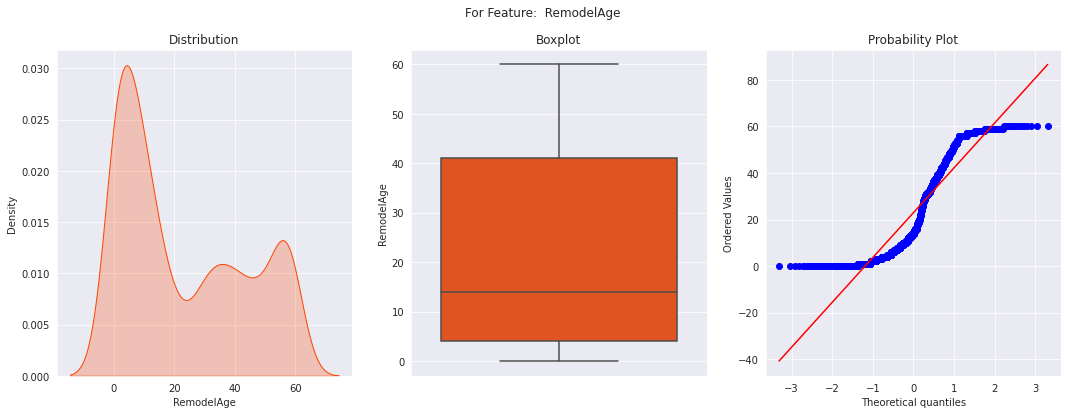

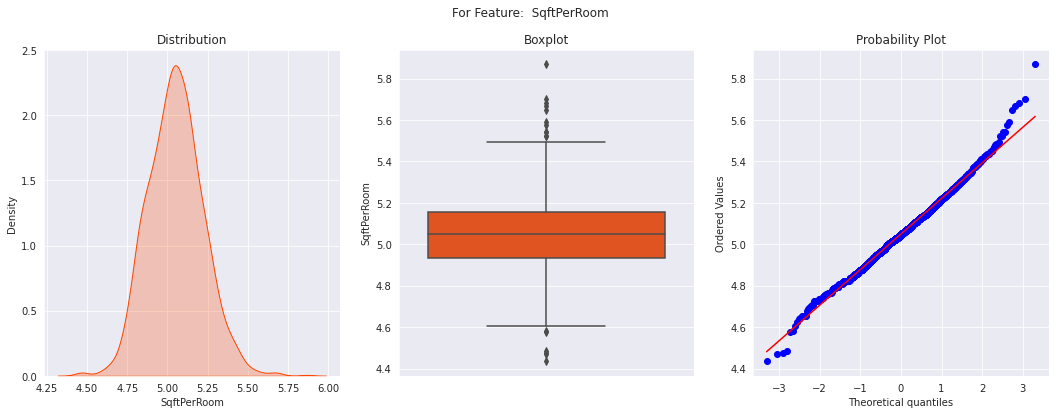

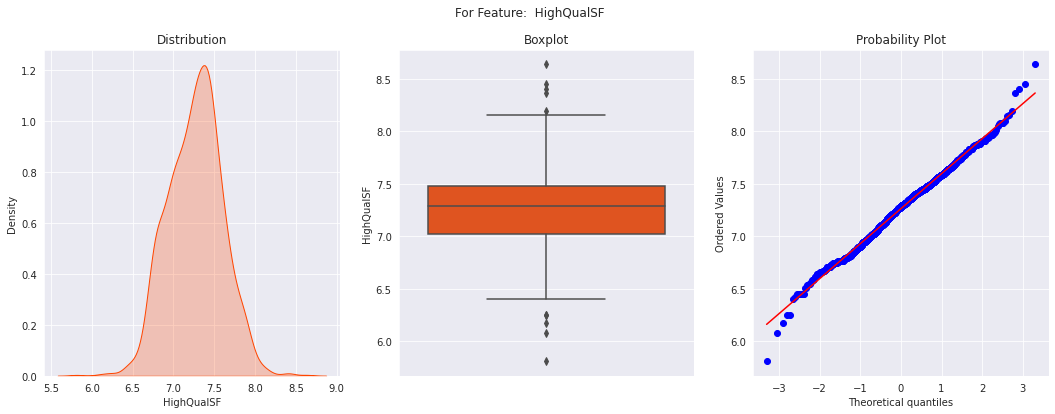

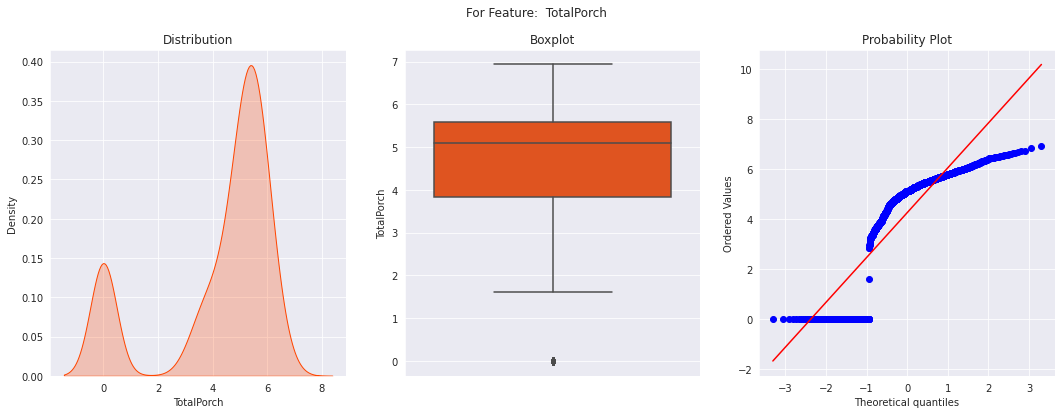

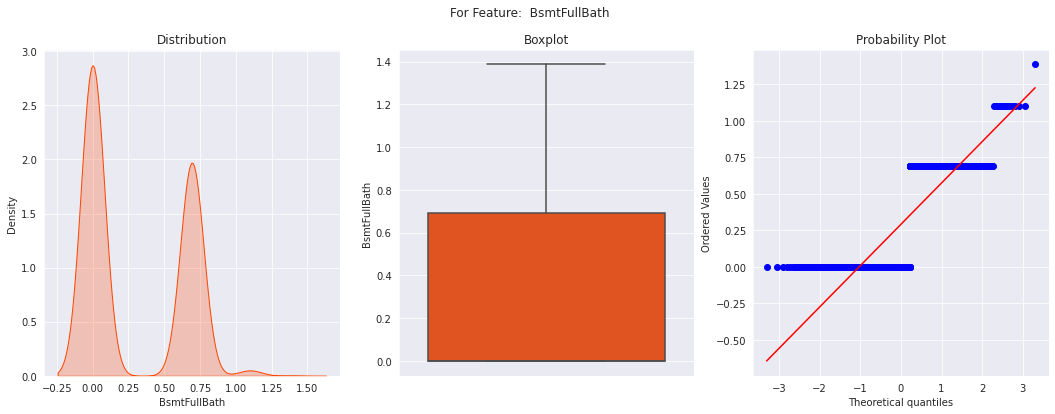

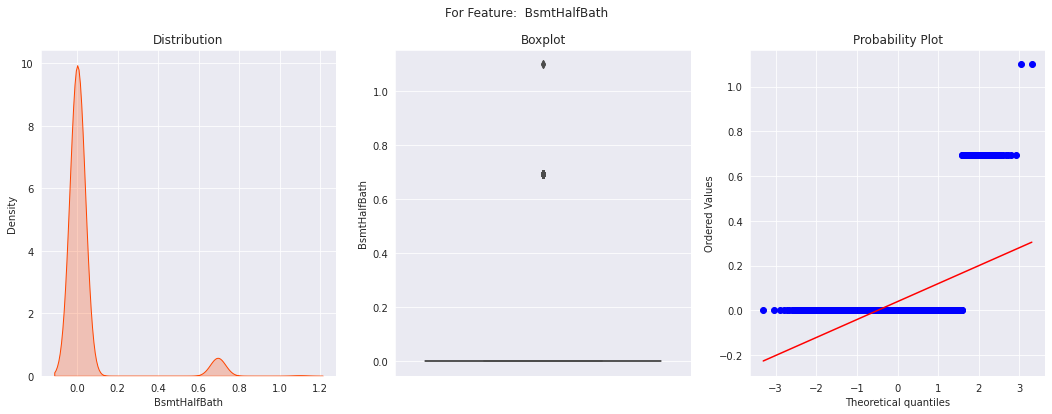

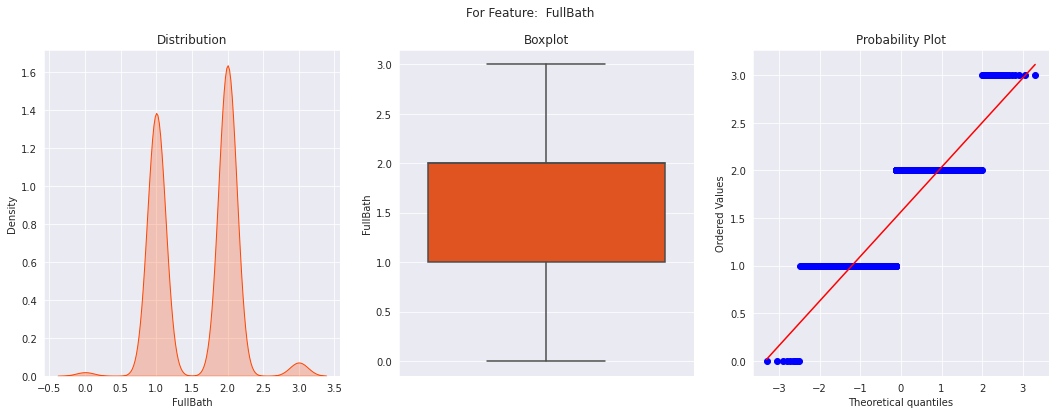

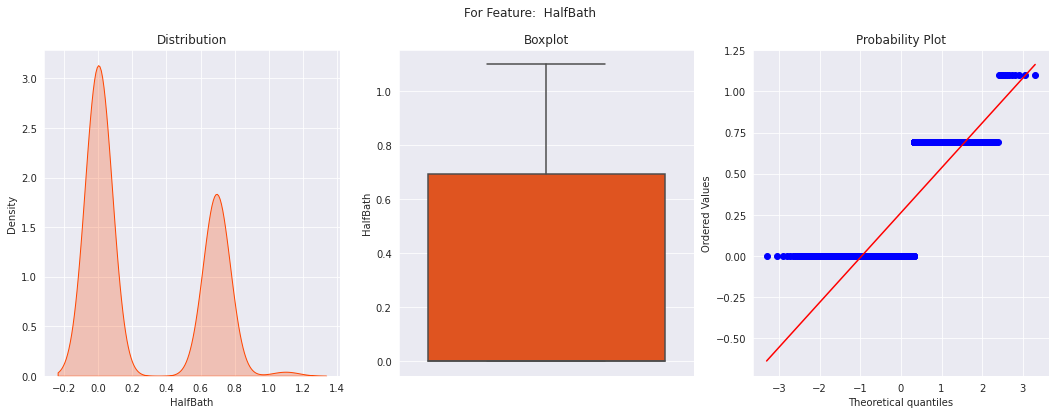

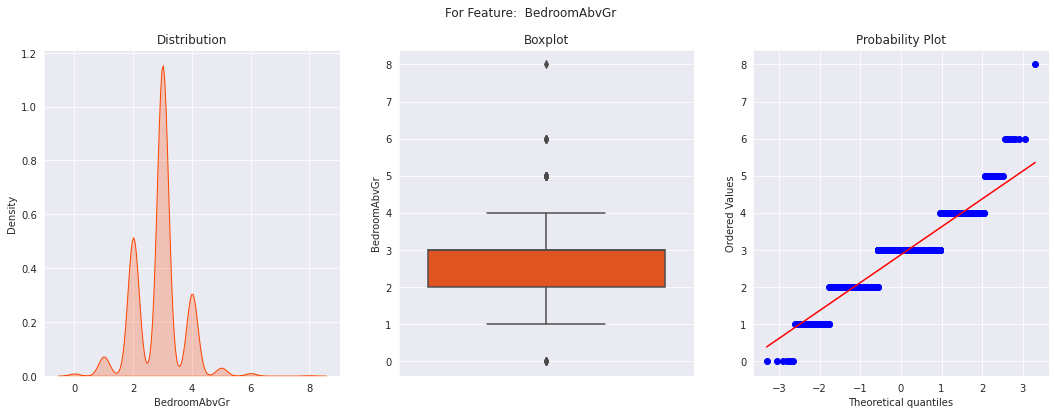

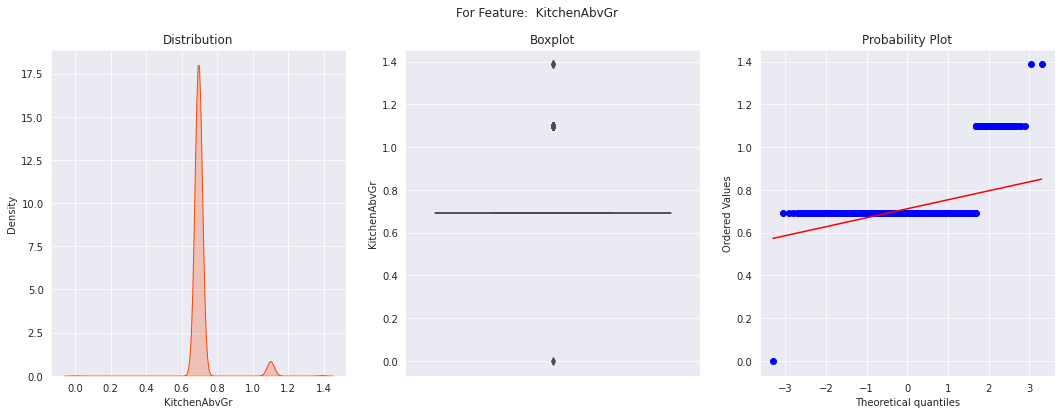

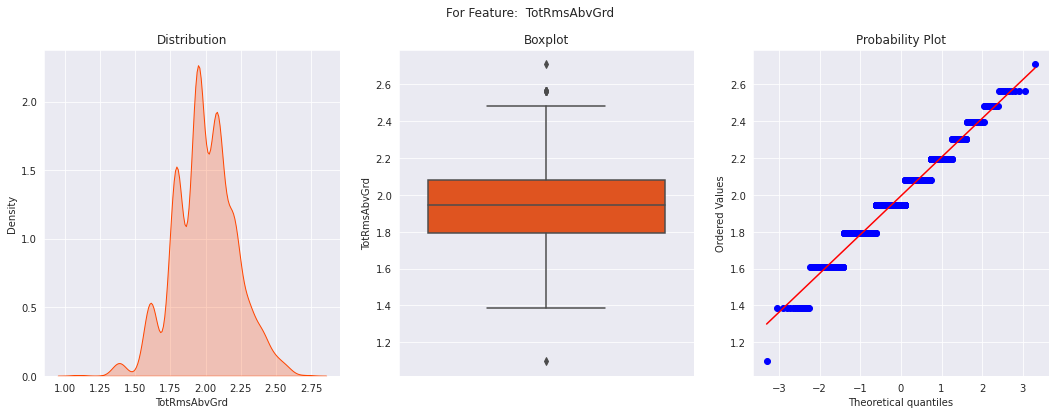

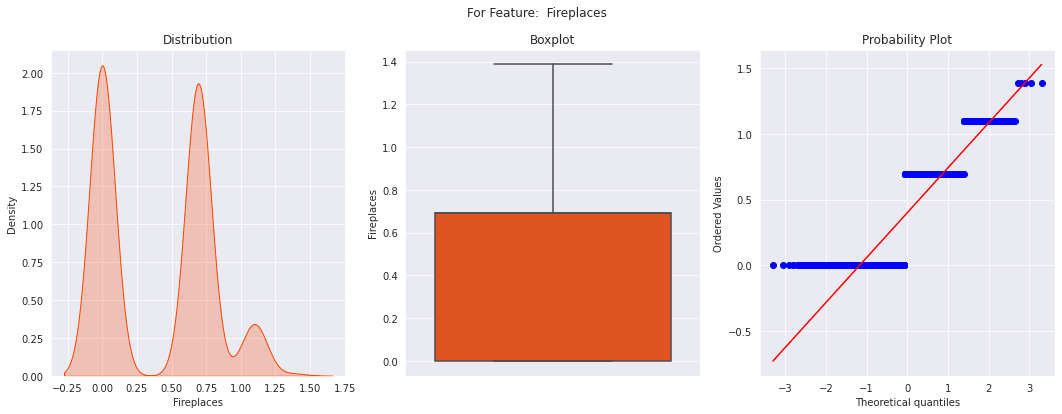

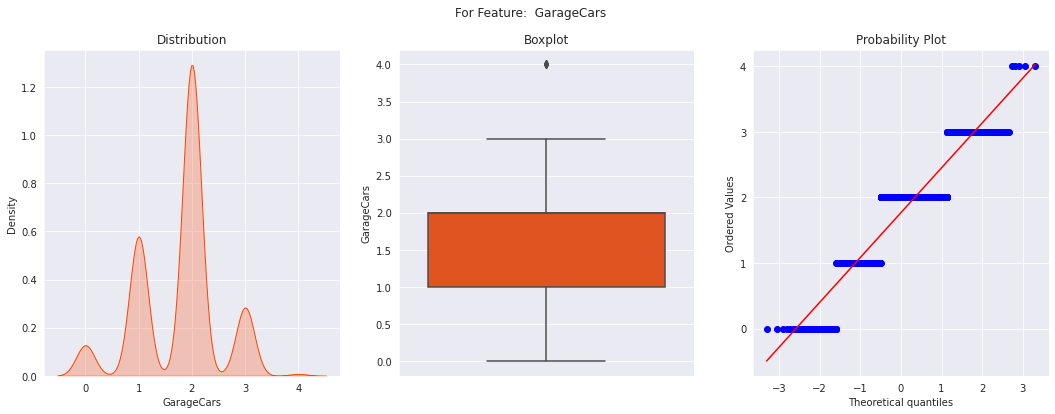

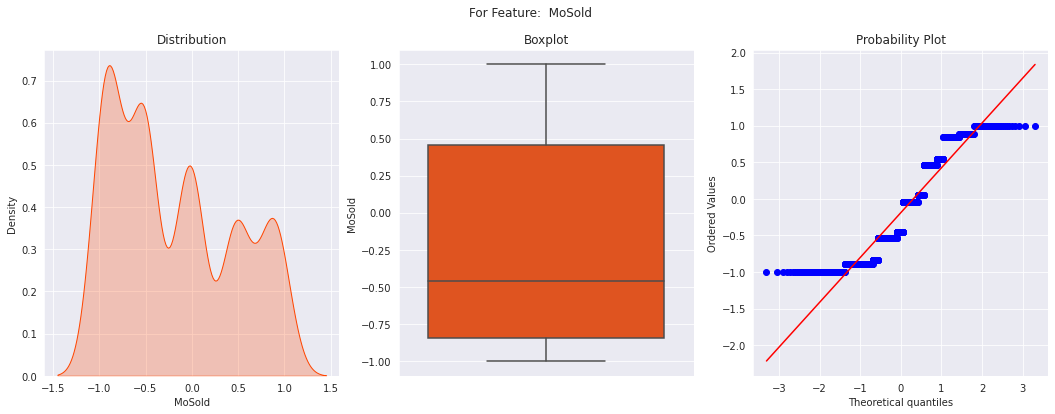

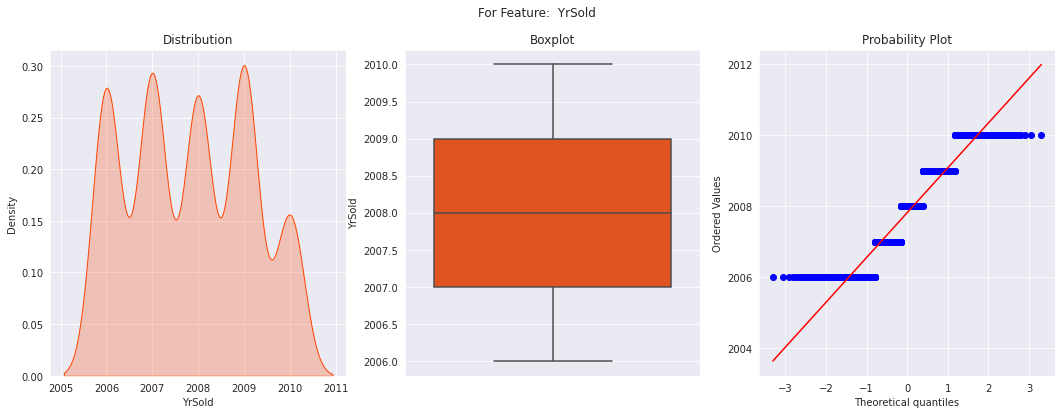

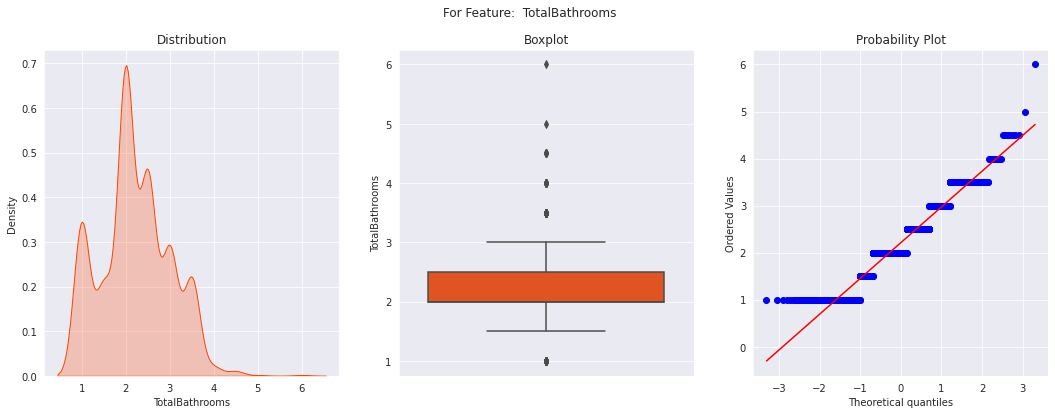

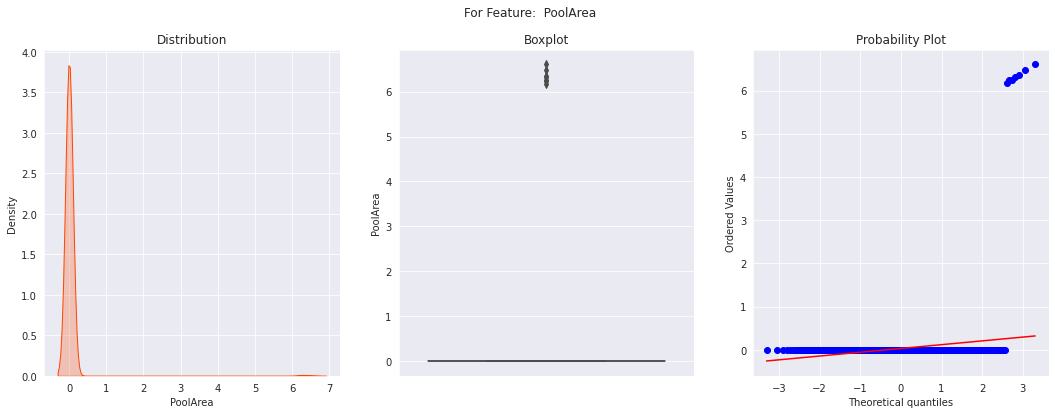

In [43]:
for col in num_cols:
    feature_distribution(train1, col, 'SalePrice', test = False)

Above are three functions to give various visualizations. 

# 3.5 Feature Selection
Most high performing models are quite robust and as such will deal with having many features very well. For now we will include all features.

# 3.6 Preprocessing
We will standard scale the numeric variable and convert columns to catagorical data type and use pd.get_dummies to create dummy variables for modeling. We will also try to preserve the ordinality of some variables.

In [44]:
data5 = data4.copy()

## Encode Catagoricals

In [45]:
from pandas.api.types import CategoricalDtype

#Tried to keep ordinal variables to be read as ordinal by pycaret. Didn't work. Likely due to the way that pandas get_dummies works.
data5[cat_cols] = data5[cat_cols].astype('category')
data5[ord_cols] = data5[ord_cols].astype(int)
ord_type = CategoricalDtype(ordered=True)
data5[ord_cols] = data5[ord_cols].astype(ord_type)
data5 = pd.get_dummies(data5)

## Scaling

In [46]:
scaler = preprocessing.StandardScaler()
scaler.fit(data5)
data6 = pd.DataFrame(scaler.transform(data5), index = data5.index, columns = data5.columns)


# 4. Model Building
We can use pycaret as a way to test many different types of models quickly in order to see what type of model works well. From there we can work more closely with those models.



In [47]:
#split the data
train2 = data6.loc[:train0.index.max(),:].copy()
train2 = pd.concat([train2, log_target], axis = 1)
test = data6.loc[train0.index.max()+ 1:,:].reset_index(drop = True).copy()
test['SalePrice'] = np.nan

In [48]:
from pycaret.regression import setup, compare_models

In [49]:
#pycaret_setup = setup(data = train2, target = "SalePrice")

The compare_models() function will tell us which models perform the best. I do not want to run it however and many of the following functions as they take a very long time.

In [50]:

#compare_models()

In [51]:
# from catboost import CatBoostRegressor
# from sklearn.linear_model import BayesianRidge, HuberRegressor, Ridge, OrthogonalMatchingPursuit
# from lightgbm import LGBMRegressor
# from sklearn.ensemble import GradientBoostingRegressor
# from xgboost import XGBRegressor



# 4.1 Baseline Model

In [52]:
target = train2['SalePrice']
train3 = train2.copy().drop('SalePrice', axis = 1)

In [53]:
baseline_model = CatBoostRegressor(verbose = 0)

In [54]:
baseline_model.fit(train3,target)

In [55]:
models = {
    'catboost' : CatBoostRegressor(verbose = 0),
    'br' : BayesianRidge(),
    'ridge': Ridge(),
    'omp': OrthogonalMatchingPursuit(),
    #'xgb': XGBRegressor(), relatively poor performance will not use
    'lgbm': LGBMRegressor()
}

# 4.2 Evaluate & Ensemble

In [56]:
results = {}

kf = KFold(n_splits = 10)

for name, model in models.items():
    result = np.exp(np.sqrt(-cross_val_score(model, train3, target, scoring = 'neg_mean_squared_error', cv = kf )))
    results[name] = result

In [57]:
for name, cv_score in results.items():
    print()
    print("CV scores for {}".format(name))
    print("mean score {}".format(np.mean(cv_score)))
    print('standard deviation {}'.format(np.std(cv_score)))



CV scores for catboost
mean score 1.1261689729623359
standard deviation 0.022199159976658524

CV scores for br
mean score 1.1390509637047845
standard deviation 0.026441605276313517

CV scores for ridge
mean score 1.1491693467958926
standard deviation 0.03095804905251577

CV scores for omp
mean score 1.142117781952107
standard deviation 0.02241331314700053

CV scores for lgbm
mean score 1.1421452471429843
standard deviation 0.02064201867741095


# 4.3 Hyperparameter Tuning

We will use optuna to perform a bayesian search for the hyperparameters. Should be a bit faster than gridsearch or randomsearch.

In [58]:
#Optuna will use a bayesian search which should be better than gridsearch
#import optuna

In [59]:
# #tuning bayesianridge
# def br_objective(trial):
#     n_iter = trial.suggest_int('n_iter',50,600)
#     tol = trial.suggest_loguniform('tolerance', 1e-7, 10)
#     alpha_1 = trial.suggest_loguniform('alpha_1', 1e-8, 10)
#     alpha_2 = trial.suggest_loguniform('alpha_2', 1e-8, 10)
#     lambda_1 = trial.suggest_loguniform('lambda_1', 1e-8, 10)
#     lambda_2 = trial.suggest_loguniform('lambda_2', 1e-8, 10)
    
#     model = BayesianRidge(
#         n_iter = n_iter,
#         tol = tol,
#         alpha_1 = alpha_1,
#         alpha_2 = alpha_2,
#         lambda_1 = lambda_1,
#         lambda_2 = lambda_2
#     )
    
#     model.fit(train3,target)
#     cv_scores = np.exp(np.sqrt(-cross_val_score(model, train3, target, scoring = 'neg_mean_squared_error', cv = kf )))
    
#     return np.mean(cv_scores)
    

In [60]:
# study_br = optuna.create_study( direction = 'minimize')
# study_br.optimize(br_objective, n_trials = 100)

In [61]:
# study_br.best_params

In [62]:


# #tuning catboost
# def catb_objective(trial):
#     iterations = trial.suggest_int('iterations',100,10000)
#     learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
#     depth = trial.suggest_int('depth', 1, 10)
#     l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 0.5, 5)    
#     model = CatBoostRegressor(verbose = 0,
#         iterations = iterations,
#         learning_rate = learning_rate,
#         depth = depth,
#         l2_leaf_reg = l2_leaf_reg,
#         eval_metric = 'RMSE',
#         early_stopping_rounds = 100
                              
#     )
    
#     model.fit(train3,target)
#     cv_scores = np.exp(np.sqrt(-cross_val_score(model, train3, target, scoring = 'neg_mean_squared_error', cv = kf )))
    
#     return np.mean(cv_scores)
    

In [63]:
# study_catb = optuna.create_study( direction = 'minimize')
# study_catb.optimize(catb_objective, n_trials = 100)

In [64]:
# study_catb.best_params

In [65]:
#tuning ridge
# def ridge_objective(trial):
#     alpha = trial.suggest_loguniform('alpha',1, 1000)
#     model = Ridge(
#         alpha = alpha,                              
#     )
    
#     model.fit(train3,target)
#     cv_scores = np.exp(np.sqrt(-cross_val_score(model, train3, target, scoring = 'neg_mean_squared_error', cv = kf )))
    
#     return np.mean(cv_scores)

In [66]:
# study_ridge = optuna.create_study( direction = 'minimize')
# study_ridge.optimize(ridge_objective, n_trials = 100)

In [67]:
# study_ridge.best_params

In [68]:
#tuning lightgbm
# def lgbm_objective(trial):
#     num_leaves = trial.suggest_int('num_leaves', 5, 50)
#     max_depth = trial.suggest_int('max_depth', 1, 10)
#     learning_rate = trial.suggest_loguniform('learning_rate', 0.001,0.5)
#     n_estimators = trial.suggest_int('n_estimators', 50, 600)
#     model = LGBMRegressor(
#         num_leaves = num_leaves,
#         max_depth = max_depth,
#         learning_rate = learning_rate,
#         n_estimators = n_estimators
#     )
    
#     model.fit(train3,target)
#     cv_scores = np.exp(np.sqrt(-cross_val_score(model, train3, target, scoring = 'neg_mean_squared_error', cv = kf )))
    
#     return np.mean(cv_scores)

In [69]:
# study_lgbm = optuna.create_study( direction = 'minimize')
# study_lgbm.optimize(lgbm_objective, n_trials = 100)

In [70]:
# study_lgbm.best_params

In [71]:
#these were all found above

catboost_params = {
    'iterations': 6000,
    'learning_rate': 0.005,
    'depth': 4,
    'l2_leaf_reg': 1,
    'eval_metric':'RMSE',
    'early_stopping_rounds': 200,
    'random_seed': 42
}

br_params = {
    'n_iter': 304,
    'tol': 0.16864712769300896,
    'alpha_1': 5.589616542154059e-07,
    'alpha_2': 9.799343618469923,
    'lambda_1': 1.7735725582463822,
    'lambda_2': 3.616928181181732e-06
}

lightgbm_params = {
        'num_leaves': 10,
     'max_depth': 6,
     'learning_rate': 0.04600339196702484,
     'n_estimators': 530
}

ridge_params = {
    'alpha': 534.124764230543
}



In [72]:
models = {
    "catboost": CatBoostRegressor(**catboost_params, verbose=0),
    "br": BayesianRidge(**br_params),
    "lightgbm": LGBMRegressor(**lightgbm_params),
    "ridge": Ridge(**ridge_params),
    "omp": OrthogonalMatchingPursuit()
}

In [73]:
for name, model in models.items():
    model.fit(train3, target)
    print(name + " trained.")



catboost trained.
br trained.
lightgbm trained.
ridge trained.
omp trained.


# 4.3 Combine Predictions
We will run the models then check the RSME. We then can combine the predictions based off of their predictive power and standard deviation.

In [74]:
results = {}

kf = KFold(n_splits = 10)

for name, model in models.items():
    result = np.exp(np.sqrt(-cross_val_score(model, train3, target, scoring = 'neg_mean_squared_error', cv = kf )))
    results[name] = result

In [75]:
for name, cv_score in results.items():
    print("-------")
    print("CV scores for {}".format(name))
    print("mean score {}".format(np.mean(cv_score)))
    print('standard deviation {}'.format(np.std(cv_score)))

-------
CV scores for catboost
mean score 1.124709502303488
standard deviation 0.021362272033386497
-------
CV scores for br
mean score 1.1352018877806853
standard deviation 0.025158757877559074
-------
CV scores for lightgbm
mean score 1.13245142927674
standard deviation 0.020922524939692957
-------
CV scores for ridge
mean score 1.134799349504186
standard deviation 0.024951448797094572
-------
CV scores for omp
mean score 1.142117781952107
standard deviation 0.02241331314700053


1.1247
1.135
1.13245
1.1348
1.142

In [76]:
test2 = test.copy()
test2.drop('SalePrice',axis = 1, inplace = True)

final_predictions = (
    0.4 * np.exp(models['catboost'].predict(test2)) +
    0.2 * np.exp(models['br'].predict(test2)) +
    0.2 * np.exp(models['lightgbm'].predict(test2)) +
    0.1 * np.exp(models['ridge'].predict(test2)) +
    0.1 * np.exp(models['omp'].predict(test2))
)



In [77]:
final_predictions

array([123091.38692738, 156735.06223874, 186453.74406662, ...,
       156308.5610119 , 119471.95306871, 216282.06837066])

## Make Submission

In [78]:
submission = pd.concat([test_id, pd.Series(final_predictions, name='SalePrice')], axis=1)

In [79]:
submission.to_csv('./submission.csv', index = False, header = True)

In [80]:
#final score: .12513

# Conclusions

The general flow here went pretty well, however there are a few things that could be done for improvement. I think that a pipeline for testing small changes to the model would be desirable to test changes to feature engineering or encoding. CatBoost training took an incredibly long time and made it kind of a pain to test changes.

I also read in the documentation of catboost that using pd.get_dummies is not necessarily a good idea and just coding the features as catagorical data types should be good enough. Unfortunately, most other models do make good use of the dummy variables. 
